# Model training and evaluation

In [ ]:
# Import standard libraries
import itertools
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from loguru import logger
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tqdm.notebook import tqdm
from xgboost import XGBRegressor

from nomination_predictor.config import MODELS_DIR, PROCESSED_DATA_DIR
from nomination_predictor.modeling.predict import (compare_models,
                                                   evaluate_and_report_model,
                                                   train_and_evaluate_model)
from nomination_predictor.modeling.train import save_model_with_metadata

2025-07-18 15:30:50.003 | INFO     | nomination_predictor.config:<module>:103 - Project root: /home/wsl2ubuntuuser/nomination_predictor
2025-07-18 15:30:50.004 | INFO     | nomination_predictor.config:<module>:127 - Configuration loaded


In [ ]:
df = pd.read_csv(PROCESSED_DATA_DIR/"processed.csv")

# Verify GPU availability

In [ ]:
# Verify current GPU setup
import subprocess

import xgboost as xgb

print(f"📦 XGBoost version: {xgb.__version__}")

# Test GPU availability
try:
    result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'], 
                          capture_output=True, text=True)
    if result.returncode == 0:
        print("✅ GPU detected:")
        for line in result.stdout.strip().split('\n'):
            print(f"  🔹 {line}")
    else:
        print("❌ nvidia-smi failed")
except FileNotFoundError:
    print("❌ nvidia-smi not found")

# Test XGBoost GPU support
try:
    test_model = xgb.XGBRegressor(tree_method="hist", device="cuda")
    print("✅ XGBoost GPU support confirmed with current syntax!")
except Exception as e:
    print(f"❌ XGBoost GPU issue: {e}")

📦 XGBoost version: 3.0.2
✅ GPU detected:
  🔹 NVIDIA GeForce RTX 3070, 8192 MiB
  🔹 NVIDIA GeForce RTX 2060, 6144 MiB
✅ XGBoost GPU support confirmed with current syntax!


# Choose features

## target variable

In [ ]:
TARGET = "days_nom_to_conf"

# pick target and drop Y label targets from features
y = df[TARGET]
X = df.drop(columns=[TARGET, "days_nom_to_latest_action"])  # other target saved for later tries at modeling

## numeric features

In [ ]:
NUMERIC_FEATURES = [
    "actions_count",
    "age_at_nom_days",
    "birth_year", 
    "committees_count",
    "congress_num", 
    "days_into_pres_term",
    "days_nom_to_deceased",
    "days_to_next_midterm_election",
    "days_to_next_pres_election",
    "death_year", 
    "degree_year", 
    "education_sequence", 
    "fed_service_sequence", 
    "highest_degree_level",
    "professional_career_sequence",
    "record_vote_number",   
    "service_as_chief_judge,_begin", 
    "service_as_chief_judge,_end",
]

# boolean features

In [ ]:
BOOLEAN_FEATURES = [
    "pres_term_is_latter_term", 
    "statute_authorized_new_seat_bool",
]

# categorical features

In [ ]:
CATEGORICAL_FEATURES  = [
    "aba_rating", 
    "appointing_president",
    "congress_session",
    "court_type",
    "birth_state",
    "latestaction_is_div_opp_house",
    "latestaction_is_div_opp_senate",
    "latestaction_is_fully_div",
    "latestaction_is_unified",
    "nomination_vacancy_reason",
    "nomination_of_or_from_location",
    "nomination_to_position_title",
    "nomination_to_court_name",
    "nominees_0_organization",
    "nominees_0_state",
    "nomination_term_years", # sounds numeric but only few options, including lifetime
    "party_of_appointing_president",
    "race_or_ethnicity",
    "received_in_senate_political_era",
    "school",
    "seat_level_cong_recategorized",
    "seat_id_letters_only",
    "senate_vote_type"
]

In [ ]:
from nomination_predictor.modeling.train import validate_feature_lists

are_features_unique = validate_feature_lists(NUMERIC_FEATURES, BOOLEAN_FEATURES, CATEGORICAL_FEATURES)

if not are_features_unique:
    raise ValueError("Feature lists contain duplicates. Please fix before continuing.")

✅ All features are unique across feature type lists
ℹ️ Total unique features: 43


In [ ]:
if len([col for col in NUMERIC_FEATURES if col not in df.columns]) > 0:
    logger.warning("The following columns in NUMERIC_FEATURES are absent from the df: {}".format(
        [col for col in NUMERIC_FEATURES if col not in df.columns],
    ))
if len([col for col in BOOLEAN_FEATURES if col not in df.columns]) > 0:
    logger.warning("The following columns in BOOLEAN_FEATURES are absent from the df: {}".format(
        [col for col in BOOLEAN_FEATURES if col not in df.columns],
    ))
if len([col for col in CATEGORICAL_FEATURES if col not in df.columns]) > 0:
    logger.warning("The following columns in CATEGORICAL_FEATURES are absent from the df: {}".format(
        [col for col in CATEGORICAL_FEATURES if col not in df.columns],
    ))

In [ ]:
cat_cols = df.select_dtypes("object").columns.tolist()
num_cols = [
    c for c in df.select_dtypes("number").columns
    if c not in {TARGET}
]

df_model = df[df[TARGET].notna()].copy()
X = df_model[BOOLEAN_FEATURES + CATEGORICAL_FEATURES + NUMERIC_FEATURES]
y = df_model[TARGET]

# splitting training and testing data

In [ ]:
from sklearn.model_selection import train_test_split

# Create composite strata
strata = (
    df_model["seat_level_cong_recategorized"].astype(str)
    + "__"
    + df_model["received_in_senate_political_era"].astype(str)
)

# Optionally collapse very-rare strata to 'Other' (prevents ValueError)
min_count = 3          # tweak as needed
rare_mask = strata.map(strata.value_counts()) < min_count
strata = strata.where(~rare_mask, other="Other")

# Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
    stratify=strata,
)

In [ ]:
# I'm normally accustomed to naming python constants with all-caps, but my code assist tools are insisting on making these lowercase, so we'll alias them just to appease it
numerical_features = NUMERIC_FEATURES
categorical_features = CATEGORICAL_FEATURES

# Model Selection, Training, and Evaluation

##  Preprocessing pipeline setup

Given how much data cleaning is(n't) happening so far, it's entirely possible the test data will contain something the training pipeline has never seen in the training data.

An example of an error message it threw when this occurred was `ValueError: Found unknown categories ['Syria', 'Russia', 'Trinidad and Tobago', 'Panama'] in column 4 during transform`, presumably because all of those were locations nominees have been appointed to work at or work with.

The simplest workaround is to ignore them until/unless enough feature-engineering can be done to re-bin them (e.g. by continent, or job type, etc.)

In [ ]:
# Fixed preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(
            drop='first', 
            sparse_output=False,
            handle_unknown='ignore'  # 🔧 workaround for error described in a markdown cell above
        ), categorical_features)
    ]
)

## Untuned / naive pipeline

In [ ]:
baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        tree_method="hist",      # ✅ Current way
        device="cuda",           # ✅ Current way (replaces gpu_id, predictor, etc.)
        n_estimators=500,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    ))
])

## Training & Evaluation

### Choice of metric: MAE

Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) are both sensitive to outliers, and MSE also doesn't use the same units as our target variable, making it less intuitive.

After all our data cleaning, we have few-enough rows of data, with outliers occurring often-enough, that I'm selecting Mean Absolute Error (MAE) as our metric.

In [ ]:
# Train and evaluate baseline model
baseline_results = train_and_evaluate_model(
    model=baseline_pipeline,  # ✅ Use the actual pipeline variable name
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    model_name="XGBoost Baseline",
    show_progress=True
)

2025-07-18 15:30:50.619 | INFO     | nomination_predictor.modeling.predict:train_and_evaluate_model:46 - Training XGBoost Baseline on 1424 samples, 43 features


Training XGBoost Baseline: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it]


2025-07-18 15:30:53.933 | INFO     | nomination_predictor.modeling.predict:train_and_evaluate_model:58 - Training completed in 3.31 seconds


Making predictions:   0%|          | 0/2 [00:00<?, ?it/s]/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [15:30:53] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
Making predictions:  50%|█████     | 1/2 [00:00<00:00,  9.20it/s]/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Maki

## Saving with evaluation metadata

In [ ]:
baseline_final = evaluate_and_report_model(
    results=baseline_results,
    y_train=y_train,
    y_test=y_test,
    model_name="XGBoost Baseline",
    save_model=True,
    hyperparameters={
        "n_estimators": 500,
        "max_depth": 6,
        "learning_rate": 0.1,
        "random_state": 42,
        "tree_method": "hist",
        "device": "cuda"
    }
)


📊 XGBOOST BASELINE EVALUATION RESULTS

🎯 PERFORMANCE METRICS:
  • Training MAE: 10.46 days
  • Test MAE:     47.05 days
  • Training R²:  0.9693
  • Test R²:      0.3599
  • Training time: 3.31 seconds

===== Mean Absolute Error (MAE): 47.05 =====
📊 GOOD: The model's predictions are typically within 60 days of the actual confirmation time.
🔍 TAKEAWAY: The model provides valuable insights but has moderate error margins.

===== R² Score: 0.3599 =====
📊 FAIR: The model explains between 30-50% of the variance in confirmation times.
🔍 TAKEAWAY: The model identifies some patterns but misses many important factors.

===== Interpretation in Context =====
• The average nomination takes 126 days to confirm
• With a standard deviation of 85 days
• Our model's error (MAE) is 47 days, which is 55% of the standard deviation
• This means our model outperforms a baseline model that always predicts the average

===== Recommended Next Steps =====
1. Tune hyperparameters to optimize model performance
2.

2025-07-18 15:30:54.142 | INFO     | nomination_predictor.modeling.train:save_model_with_metadata:249 - Model saved successfully to /home/wsl2ubuntuuser/nomination_predictor/models/xgboost_baseline_2025-07-18_153054.pkl
2025-07-18 15:30:54.144 | INFO     | nomination_predictor.modeling.train:save_model_with_metadata:250 - Model metadata: xgboost_baseline with 43 features

💾 Model saved to: /home/wsl2ubuntuuser/nomination_predictor/models/xgboost_baseline_2025-07-18_153054.pkl


# Model tuning via randomized hyper-parameter search

## Define hyperparameter search space

In [ ]:

from nomination_predictor.modeling.train import (PARAMETER_REFINEMENT_CONFIG,
                                                 create_refined_param_grid,
                                                 create_refined_range)

# Choose your initial parameter distribution based on time budget
# Option 1: Quick search (similar to your original - 11-12 minutes)
param_distributions_quick = {
    'model__n_estimators': [100, 500, 1000, 2000, 3000],
    'model__max_depth': [3, 4, 5, 6, 7, 8, 9],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'model__reg_alpha': [0, 0.1, 0.5, 1.0],
    'model__reg_lambda': [0, 0.1, 0.5, 1.0],
    'model__min_child_weight': [1, 3, 5, 7],
    'model__gamma': [0, 0.1, 0.2, 0.3]
}

# Option 2: Moderate search (1-2 hours)
param_distributions_moderate = {
    'model__n_estimators': [100, 500, 1000, 2000, 3000, 5000],
    'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
    'model__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'model__reg_alpha': [0, 0.1, 0.5, 1.0, 2.0],
    'model__reg_lambda': [0, 0.1, 0.5, 1.0, 2.0],
    'model__min_child_weight': [1, 3, 5, 7, 10],
    'model__gamma': [0, 0.1, 0.2, 0.3, 0.5]
}

# Option 3: Comprehensive search (5-6 hours) - CLEANED UP VERSION
param_distributions_comprehensive = {
    'model__n_estimators': [100, 300, 500, 1000, 1500, 2000, 3000, 5000, 7000],
    'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 12],
    'model__learning_rate': [0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3],
    'model__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__reg_alpha': [0, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
    'model__reg_lambda': [0, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
    'model__min_child_weight': [1, 3, 5, 7, 10, 15],
    'model__gamma': [0, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0],
    # Note: Removed max_delta_step and scale_pos_weight as they're not typically used in regression
}

## Configurability based on available time budget

In [ ]:
# 🎯 CHOOSE YOUR TIME BUDGET - uncomment one of these:
# chosen_params = param_distributions_quick      # ~15 minutes
chosen_params = param_distributions_moderate   # ~1-2 hours  
# chosen_params = param_distributions_comprehensive  # ~5-6 hours

In [ ]:
print(f"📊 Selected parameter space with {len(chosen_params)} parameters")
for param, values in chosen_params.items():
    print(f"  {param}: {len(values)} values")

📊 Selected parameter space with 9 parameters
  model__n_estimators: 6 values
  model__max_depth: 8 values
  model__learning_rate: 6 values
  model__subsample: 5 values
  model__colsample_bytree: 5 values
  model__reg_alpha: 5 values
  model__reg_lambda: 5 values
  model__min_child_weight: 5 values
  model__gamma: 5 values


## Tuned pipeline

In [ ]:
tuned_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        tree_method="hist",        # GPU acceleration
        device="cuda",             # GPU acceleration  
        random_state=42,
        n_jobs=-1,
        # No early stopping - let RandomizedSearchCV handle optimization; early stopping option may as well be mutually exclusive with multi-stage search
        eval_metric='mae'          # Still monitor MAE for logging
    ))
])

## Multi-stage randomized search

In [ ]:
print("🚀 Starting GPU-accelerated hyperparameter search...")

🚀 Starting GPU-accelerated hyperparameter search...


In [ ]:
# 🚀 STAGE 1: Coarse Search
print("\n🔍 STAGE 1: Coarse hyperparameter search...")
coarse_search = RandomizedSearchCV(
    tuned_pipeline,
    param_distributions=chosen_params,
    n_iter=60,  # Adjust based on your time budget
    cv=3,       # Faster CV for initial search
    scoring='neg_mean_absolute_error',
    n_jobs=1,   # Important for GPU
    random_state=42,
    verbose=2
)


🔍 STAGE 1: Coarse hyperparameter search...


In [ ]:
print(f"⏱️  Starting coarse search with {coarse_search.n_iter} iterations...")
coarse_search.fit(X_train, y_train)

print(f"✅ Stage 1 complete!")
print(f"📈 Best coarse score: {-coarse_search.best_score_:.2f} MAE")
print(f"🎯 Best parameters from coarse search:")
for param, value in coarse_search.best_params_.items():
    print(f"  {param}: {value}")

⏱️  Starting coarse search with 60 iterations...
Fitting 3 folds for each of 60 candidates, totalling 180 fits


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.5, model__learning_rate=0.1, model__max_depth=6, model__min_child_weight=3, model__n_estimators=5000, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.9; total time=  16.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.5, model__learning_rate=0.1, model__max_depth=6, model__min_child_weight=3, model__n_estimators=5000, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.9; total time=  19.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.5, model__learning_rate=0.1, model__max_depth=6, model__min_child_weight=3, model__n_estimators=5000, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.9; total time=  20.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.3, model__learning_rate=0.3, model__max_depth=6, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=2.0, model__subsample=0.8; total time=   5.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.3, model__learning_rate=0.3, model__max_depth=6, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=2.0, model__subsample=0.8; total time=   5.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.3, model__learning_rate=0.3, model__max_depth=6, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=2.0, model__subsample=0.8; total time=   5.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.2, model__learning_rate=0.1, model__max_depth=6, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=2.0, model__reg_lambda=0.5, model__subsample=1.0; total time=   4.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.2, model__learning_rate=0.1, model__max_depth=6, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=2.0, model__reg_lambda=0.5, model__subsample=1.0; total time=   4.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.2, model__learning_rate=0.1, model__max_depth=6, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=2.0, model__reg_lambda=0.5, model__subsample=1.0; total time=   4.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.2, model__max_depth=5, model__min_child_weight=7, model__n_estimators=1000, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.7; total time=   6.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.2, model__max_depth=5, model__min_child_weight=7, model__n_estimators=1000, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.7; total time=   5.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.2, model__max_depth=5, model__min_child_weight=7, model__n_estimators=1000, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.7; total time=   6.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.1, model__learning_rate=0.05, model__max_depth=9, model__min_child_weight=10, model__n_estimators=3000, model__reg_alpha=0.5, model__reg_lambda=2.0, model__subsample=1.0; total time=  18.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.1, model__learning_rate=0.05, model__max_depth=9, model__min_child_weight=10, model__n_estimators=3000, model__reg_alpha=0.5, model__reg_lambda=2.0, model__subsample=1.0; total time=  18.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.1, model__learning_rate=0.05, model__max_depth=9, model__min_child_weight=10, model__n_estimators=3000, model__reg_alpha=0.5, model__reg_lambda=2.0, model__subsample=1.0; total time=  17.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.2, model__learning_rate=0.1, model__max_depth=9, model__min_child_weight=7, model__n_estimators=500, model__reg_alpha=0, model__reg_lambda=0.5, model__subsample=0.8; total time=   4.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.2, model__learning_rate=0.1, model__max_depth=9, model__min_child_weight=7, model__n_estimators=500, model__reg_alpha=0, model__reg_lambda=0.5, model__subsample=0.8; total time=   5.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.2, model__learning_rate=0.1, model__max_depth=9, model__min_child_weight=7, model__n_estimators=500, model__reg_alpha=0, model__reg_lambda=0.5, model__subsample=0.8; total time=   5.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.1, model__learning_rate=0.3, model__max_depth=5, model__min_child_weight=7, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=0.5, model__subsample=0.7; total time=   2.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.1, model__learning_rate=0.3, model__max_depth=5, model__min_child_weight=7, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=0.5, model__subsample=0.7; total time=   2.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.1, model__learning_rate=0.3, model__max_depth=5, model__min_child_weight=7, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=0.5, model__subsample=0.7; total time=   3.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.5, model__learning_rate=0.3, model__max_depth=3, model__min_child_weight=7, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=2.0, model__subsample=0.7; total time=   1.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.5, model__learning_rate=0.3, model__max_depth=3, model__min_child_weight=7, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=2.0, model__subsample=0.7; total time=   1.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.5, model__learning_rate=0.3, model__max_depth=3, model__min_child_weight=7, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=2.0, model__subsample=0.7; total time=   2.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.1, model__learning_rate=0.3, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.8; total time=  16.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.1, model__learning_rate=0.3, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.8; total time=  17.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.1, model__learning_rate=0.3, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.8; total time=  17.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=0.7; total time=  17.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=0.7; total time=  16.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=0.7; total time=  17.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.15, model__max_depth=6, model__min_child_weight=10, model__n_estimators=3000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=1.0; total time=  12.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.15, model__max_depth=6, model__min_child_weight=10, model__n_estimators=3000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=1.0; total time=  15.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.15, model__max_depth=6, model__min_child_weight=10, model__n_estimators=3000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=1.0; total time=  12.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0.5, model__learning_rate=0.1, model__max_depth=6, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.9; total time=  10.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0.5, model__learning_rate=0.1, model__max_depth=6, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.9; total time=  10.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0.5, model__learning_rate=0.1, model__max_depth=6, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.9; total time=  12.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.15, model__max_depth=6, model__min_child_weight=5, model__n_estimators=3000, model__reg_alpha=2.0, model__reg_lambda=0.1, model__subsample=0.6; total time=  21.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.15, model__max_depth=6, model__min_child_weight=5, model__n_estimators=3000, model__reg_alpha=2.0, model__reg_lambda=0.1, model__subsample=0.6; total time=  18.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.15, model__max_depth=6, model__min_child_weight=5, model__n_estimators=3000, model__reg_alpha=2.0, model__reg_lambda=0.1, model__subsample=0.6; total time=  18.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=7, model__n_estimators=3000, model__reg_alpha=0, model__reg_lambda=0, model__subsample=0.8; total time=  12.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=7, model__n_estimators=3000, model__reg_alpha=0, model__reg_lambda=0, model__subsample=0.8; total time=  12.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=7, model__n_estimators=3000, model__reg_alpha=0, model__reg_lambda=0, model__subsample=0.8; total time=  13.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.2, model__max_depth=7, model__min_child_weight=3, model__n_estimators=1000, model__reg_alpha=0.1, model__reg_lambda=0, model__subsample=0.6; total time=   5.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.2, model__max_depth=7, model__min_child_weight=3, model__n_estimators=1000, model__reg_alpha=0.1, model__reg_lambda=0, model__subsample=0.6; total time=   6.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.2, model__max_depth=7, model__min_child_weight=3, model__n_estimators=1000, model__reg_alpha=0.1, model__reg_lambda=0, model__subsample=0.6; total time=   5.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.05, model__max_depth=7, model__min_child_weight=7, model__n_estimators=100, model__reg_alpha=2.0, model__reg_lambda=2.0, model__subsample=0.7; total time=   0.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.05, model__max_depth=7, model__min_child_weight=7, model__n_estimators=100, model__reg_alpha=2.0, model__reg_lambda=2.0, model__subsample=0.7; total time=   1.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.05, model__max_depth=7, model__min_child_weight=7, model__n_estimators=100, model__reg_alpha=2.0, model__reg_lambda=2.0, model__subsample=0.7; total time=   0.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=5, model__n_estimators=3000, model__reg_alpha=0.1, model__reg_lambda=1.0, model__subsample=0.6; total time=  22.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=5, model__n_estimators=3000, model__reg_alpha=0.1, model__reg_lambda=1.0, model__subsample=0.6; total time=  20.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=5, model__n_estimators=3000, model__reg_alpha=0.1, model__reg_lambda=1.0, model__subsample=0.6; total time=  22.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.2, model__learning_rate=0.15, model__max_depth=4, model__min_child_weight=1, model__n_estimators=500, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.8; total time=   2.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.2, model__learning_rate=0.15, model__max_depth=4, model__min_child_weight=1, model__n_estimators=500, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.8; total time=   3.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.2, model__learning_rate=0.15, model__max_depth=4, model__min_child_weight=1, model__n_estimators=500, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.8; total time=   4.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.5, model__learning_rate=0.15, model__max_depth=8, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=0.1, model__subsample=1.0; total time=   6.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.5, model__learning_rate=0.15, model__max_depth=8, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=0.1, model__subsample=1.0; total time=   4.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.5, model__learning_rate=0.15, model__max_depth=8, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=0.1, model__subsample=1.0; total time=   4.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.1, model__max_depth=3, model__min_child_weight=3, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=1.0, model__subsample=0.8; total time=   2.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.1, model__max_depth=3, model__min_child_weight=3, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=1.0, model__subsample=0.8; total time=   2.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.1, model__max_depth=3, model__min_child_weight=3, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=1.0, model__subsample=0.8; total time=   2.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.3, model__learning_rate=0.2, model__max_depth=3, model__min_child_weight=1, model__n_estimators=100, model__reg_alpha=0.1, model__reg_lambda=0, model__subsample=1.0; total time=   0.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.3, model__learning_rate=0.2, model__max_depth=3, model__min_child_weight=1, model__n_estimators=100, model__reg_alpha=0.1, model__reg_lambda=0, model__subsample=1.0; total time=   0.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.3, model__learning_rate=0.2, model__max_depth=3, model__min_child_weight=1, model__n_estimators=100, model__reg_alpha=0.1, model__reg_lambda=0, model__subsample=1.0; total time=   0.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.05, model__max_depth=4, model__min_child_weight=5, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=0.1, model__subsample=1.0; total time=   9.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.05, model__max_depth=4, model__min_child_weight=5, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=0.1, model__subsample=1.0; total time=  10.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.05, model__max_depth=4, model__min_child_weight=5, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=0.1, model__subsample=1.0; total time=  10.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.1, model__max_depth=9, model__min_child_weight=5, model__n_estimators=5000, model__reg_alpha=0.1, model__reg_lambda=0, model__subsample=1.0; total time=  39.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.1, model__max_depth=9, model__min_child_weight=5, model__n_estimators=5000, model__reg_alpha=0.1, model__reg_lambda=0, model__subsample=1.0; total time=  22.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.1, model__max_depth=9, model__min_child_weight=5, model__n_estimators=5000, model__reg_alpha=0.1, model__reg_lambda=0, model__subsample=1.0; total time=  23.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.3, model__max_depth=4, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=2.0, model__reg_lambda=0, model__subsample=1.0; total time=  10.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.3, model__max_depth=4, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=2.0, model__reg_lambda=0, model__subsample=1.0; total time=  10.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.3, model__max_depth=4, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=2.0, model__reg_lambda=0, model__subsample=1.0; total time=  11.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.3, model__learning_rate=0.1, model__max_depth=7, model__min_child_weight=3, model__n_estimators=2000, model__reg_alpha=0.5, model__reg_lambda=0.1, model__subsample=0.8; total time=  10.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.3, model__learning_rate=0.1, model__max_depth=7, model__min_child_weight=3, model__n_estimators=2000, model__reg_alpha=0.5, model__reg_lambda=0.1, model__subsample=0.8; total time=  10.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.3, model__learning_rate=0.1, model__max_depth=7, model__min_child_weight=3, model__n_estimators=2000, model__reg_alpha=0.5, model__reg_lambda=0.1, model__subsample=0.8; total time=  10.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.5, model__learning_rate=0.05, model__max_depth=9, model__min_child_weight=5, model__n_estimators=5000, model__reg_alpha=0.5, model__reg_lambda=0, model__subsample=0.6; total time=  27.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.5, model__learning_rate=0.05, model__max_depth=9, model__min_child_weight=5, model__n_estimators=5000, model__reg_alpha=0.5, model__reg_lambda=0, model__subsample=0.6; total time=  24.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.5, model__learning_rate=0.05, model__max_depth=9, model__min_child_weight=5, model__n_estimators=5000, model__reg_alpha=0.5, model__reg_lambda=0, model__subsample=0.6; total time=  24.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=6, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.7; total time=   3.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=6, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.7; total time=   4.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=6, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.7; total time=   3.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.3, model__learning_rate=0.1, model__max_depth=10, model__min_child_weight=5, model__n_estimators=5000, model__reg_alpha=0, model__reg_lambda=0.5, model__subsample=0.9; total time=  21.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.3, model__learning_rate=0.1, model__max_depth=10, model__min_child_weight=5, model__n_estimators=5000, model__reg_alpha=0, model__reg_lambda=0.5, model__subsample=0.9; total time=  22.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.3, model__learning_rate=0.1, model__max_depth=10, model__min_child_weight=5, model__n_estimators=5000, model__reg_alpha=0, model__reg_lambda=0.5, model__subsample=0.9; total time=  20.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0.2, model__learning_rate=0.3, model__max_depth=7, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0, model__subsample=0.9; total time=   3.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0.2, model__learning_rate=0.3, model__max_depth=7, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0, model__subsample=0.9; total time=   3.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0.2, model__learning_rate=0.3, model__max_depth=7, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0, model__subsample=0.9; total time=   3.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=9, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=0.1, model__reg_lambda=2.0, model__subsample=0.7; total time=  12.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=9, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=0.1, model__reg_lambda=2.0, model__subsample=0.7; total time=  11.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=9, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=0.1, model__reg_lambda=2.0, model__subsample=0.7; total time=  13.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.1, model__max_depth=4, model__min_child_weight=7, model__n_estimators=5000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=1.0; total time=  21.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.1, model__max_depth=4, model__min_child_weight=7, model__n_estimators=5000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=1.0; total time=  19.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.1, model__max_depth=4, model__min_child_weight=7, model__n_estimators=5000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=1.0; total time=  19.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.05, model__max_depth=8, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=0.1, model__subsample=0.7; total time=   4.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.05, model__max_depth=8, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=0.1, model__subsample=0.7; total time=   4.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.05, model__max_depth=8, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=0.1, model__subsample=0.7; total time=   4.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.3, model__max_depth=10, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=0.1, model__reg_lambda=0.5, model__subsample=1.0; total time=   6.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.3, model__max_depth=10, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=0.1, model__reg_lambda=0.5, model__subsample=1.0; total time=   6.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.3, model__max_depth=10, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=0.1, model__reg_lambda=0.5, model__subsample=1.0; total time=   6.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.2, model__max_depth=9, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=0.1, model__subsample=1.0; total time=   4.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.2, model__max_depth=9, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=0.1, model__subsample=1.0; total time=   4.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.2, model__max_depth=9, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=0.1, model__subsample=1.0; total time=   3.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.2, model__max_depth=9, model__min_child_weight=7, model__n_estimators=3000, model__reg_alpha=2.0, model__reg_lambda=0.1, model__subsample=0.8; total time=  10.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.2, model__max_depth=9, model__min_child_weight=7, model__n_estimators=3000, model__reg_alpha=2.0, model__reg_lambda=0.1, model__subsample=0.8; total time=  13.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.2, model__max_depth=9, model__min_child_weight=7, model__n_estimators=3000, model__reg_alpha=2.0, model__reg_lambda=0.1, model__subsample=0.8; total time=  12.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0, model__learning_rate=0.15, model__max_depth=4, model__min_child_weight=5, model__n_estimators=1000, model__reg_alpha=0, model__reg_lambda=0.5, model__subsample=0.9; total time=   6.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0, model__learning_rate=0.15, model__max_depth=4, model__min_child_weight=5, model__n_estimators=1000, model__reg_alpha=0, model__reg_lambda=0.5, model__subsample=0.9; total time=   5.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0, model__learning_rate=0.15, model__max_depth=4, model__min_child_weight=5, model__n_estimators=1000, model__reg_alpha=0, model__reg_lambda=0.5, model__subsample=0.9; total time=   5.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=1.0; total time=   4.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=1.0; total time=   4.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=1.0; total time=   5.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.1, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=0, model__reg_lambda=2.0, model__subsample=0.9; total time=  31.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.1, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=0, model__reg_lambda=2.0, model__subsample=0.9; total time=  28.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.1, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=0, model__reg_lambda=2.0, model__subsample=0.9; total time=  28.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=1.0, model__subsample=0.6; total time=   4.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=1.0, model__subsample=0.6; total time=   4.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=1.0, model__subsample=0.6; total time=   4.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0, model__learning_rate=0.05, model__max_depth=7, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=0.5, model__reg_lambda=0.1, model__subsample=0.9; total time=  31.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0, model__learning_rate=0.05, model__max_depth=7, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=0.5, model__reg_lambda=0.1, model__subsample=0.9; total time=  31.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0, model__learning_rate=0.05, model__max_depth=7, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=0.5, model__reg_lambda=0.1, model__subsample=0.9; total time=  31.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.3, model__max_depth=5, model__min_child_weight=1, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=2.0, model__subsample=0.9; total time=   2.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.3, model__max_depth=5, model__min_child_weight=1, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=2.0, model__subsample=0.9; total time=  39.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.3, model__max_depth=5, model__min_child_weight=1, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=2.0, model__subsample=0.9; total time= -33.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.1, model__learning_rate=0.2, model__max_depth=4, model__min_child_weight=1, model__n_estimators=100, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.9; total time=   0.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.1, model__learning_rate=0.2, model__max_depth=4, model__min_child_weight=1, model__n_estimators=100, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.9; total time=   0.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.1, model__learning_rate=0.2, model__max_depth=4, model__min_child_weight=1, model__n_estimators=100, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.9; total time=  37.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.2, model__learning_rate=0.15, model__max_depth=4, model__min_child_weight=7, model__n_estimators=3000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=0.9; total time= -23.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.2, model__learning_rate=0.15, model__max_depth=4, model__min_child_weight=7, model__n_estimators=3000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=0.9; total time=  13.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.2, model__learning_rate=0.15, model__max_depth=4, model__min_child_weight=7, model__n_estimators=3000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=0.9; total time=  50.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=10, model__min_child_weight=10, model__n_estimators=5000, model__reg_alpha=2.0, model__reg_lambda=2.0, model__subsample=0.6; total time= -16.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=10, model__min_child_weight=10, model__n_estimators=5000, model__reg_alpha=2.0, model__reg_lambda=2.0, model__subsample=0.6; total time=  20.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=10, model__min_child_weight=10, model__n_estimators=5000, model__reg_alpha=2.0, model__reg_lambda=2.0, model__subsample=0.6; total time=  19.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=5, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=0.8; total time=  42.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=5, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=0.8; total time= -31.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=5, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=0.8; total time=   5.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.1, model__max_depth=5, model__min_child_weight=10, model__n_estimators=2000, model__reg_alpha=0.5, model__reg_lambda=0, model__subsample=0.9; total time=  12.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.1, model__max_depth=5, model__min_child_weight=10, model__n_estimators=2000, model__reg_alpha=0.5, model__reg_lambda=0, model__subsample=0.9; total time=  12.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.1, model__max_depth=5, model__min_child_weight=10, model__n_estimators=2000, model__reg_alpha=0.5, model__reg_lambda=0, model__subsample=0.9; total time=  12.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=1, model__n_estimators=1000, model__reg_alpha=0.1, model__reg_lambda=2.0, model__subsample=1.0; total time=   8.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=1, model__n_estimators=1000, model__reg_alpha=0.1, model__reg_lambda=2.0, model__subsample=1.0; total time=   6.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=1, model__n_estimators=1000, model__reg_alpha=0.1, model__reg_lambda=2.0, model__subsample=1.0; total time=   7.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.05, model__max_depth=4, model__min_child_weight=10, model__n_estimators=5000, model__reg_alpha=2.0, model__reg_lambda=0.5, model__subsample=1.0; total time=  25.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.05, model__max_depth=4, model__min_child_weight=10, model__n_estimators=5000, model__reg_alpha=2.0, model__reg_lambda=0.5, model__subsample=1.0; total time=  23.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.05, model__max_depth=4, model__min_child_weight=10, model__n_estimators=5000, model__reg_alpha=2.0, model__reg_lambda=0.5, model__subsample=1.0; total time=  21.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.5, model__learning_rate=0.3, model__max_depth=3, model__min_child_weight=10, model__n_estimators=2000, model__reg_alpha=0.1, model__reg_lambda=1.0, model__subsample=0.6; total time=   7.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.5, model__learning_rate=0.3, model__max_depth=3, model__min_child_weight=10, model__n_estimators=2000, model__reg_alpha=0.1, model__reg_lambda=1.0, model__subsample=0.6; total time=   8.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.5, model__learning_rate=0.3, model__max_depth=3, model__min_child_weight=10, model__n_estimators=2000, model__reg_alpha=0.1, model__reg_lambda=1.0, model__subsample=0.6; total time=   7.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.2, model__learning_rate=0.2, model__max_depth=9, model__min_child_weight=7, model__n_estimators=5000, model__reg_alpha=0.1, model__reg_lambda=0.5, model__subsample=0.9; total time=  23.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.2, model__learning_rate=0.2, model__max_depth=9, model__min_child_weight=7, model__n_estimators=5000, model__reg_alpha=0.1, model__reg_lambda=0.5, model__subsample=0.9; total time=  28.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.2, model__learning_rate=0.2, model__max_depth=9, model__min_child_weight=7, model__n_estimators=5000, model__reg_alpha=0.1, model__reg_lambda=0.5, model__subsample=0.9; total time=  24.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.1, model__learning_rate=0.2, model__max_depth=5, model__min_child_weight=7, model__n_estimators=2000, model__reg_alpha=0.5, model__reg_lambda=2.0, model__subsample=0.8; total time=   9.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.1, model__learning_rate=0.2, model__max_depth=5, model__min_child_weight=7, model__n_estimators=2000, model__reg_alpha=0.5, model__reg_lambda=2.0, model__subsample=0.8; total time=   9.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.1, model__learning_rate=0.2, model__max_depth=5, model__min_child_weight=7, model__n_estimators=2000, model__reg_alpha=0.5, model__reg_lambda=2.0, model__subsample=0.8; total time=  10.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0.1, model__learning_rate=0.15, model__max_depth=3, model__min_child_weight=5, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.7; total time=   4.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0.1, model__learning_rate=0.15, model__max_depth=3, model__min_child_weight=5, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.7; total time=   5.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0.1, model__learning_rate=0.15, model__max_depth=3, model__min_child_weight=5, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.7; total time=   4.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.5, model__learning_rate=0.3, model__max_depth=6, model__min_child_weight=10, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=0, model__subsample=0.8; total time=   8.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.5, model__learning_rate=0.3, model__max_depth=6, model__min_child_weight=10, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=0, model__subsample=0.8; total time=   8.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.5, model__learning_rate=0.3, model__max_depth=6, model__min_child_weight=10, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=0, model__subsample=0.8; total time=   8.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.1, model__learning_rate=0.15, model__max_depth=9, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.6; total time=   0.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.1, model__learning_rate=0.15, model__max_depth=9, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.6; total time=   1.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.1, model__learning_rate=0.15, model__max_depth=9, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.6; total time=   1.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.2, model__learning_rate=0.2, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=0.6; total time=  17.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.2, model__learning_rate=0.2, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=0.6; total time=  17.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.2, model__learning_rate=0.2, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=0.6; total time=  19.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0.1, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=5, model__n_estimators=1000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=1.0; total time=   8.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0.1, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=5, model__n_estimators=1000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=1.0; total time=   7.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0.1, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=5, model__n_estimators=1000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=1.0; total time=   7.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=7, model__min_child_weight=10, model__n_estimators=3000, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.6; total time=  14.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=7, model__min_child_weight=10, model__n_estimators=3000, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.6; total time=  14.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=7, model__min_child_weight=10, model__n_estimators=3000, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.6; total time=  13.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=6, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.7; total time=  13.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=6, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.7; total time=  14.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=6, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.7; total time=  14.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0, model__learning_rate=0.3, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=0.5, model__reg_lambda=1.0, model__subsample=0.6; total time=  14.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0, model__learning_rate=0.3, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=0.5, model__reg_lambda=1.0, model__subsample=0.6; total time=  14.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0, model__learning_rate=0.3, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=0.5, model__reg_lambda=1.0, model__subsample=0.6; total time=  14.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0, model__learning_rate=0.2, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=0.1, model__reg_lambda=2.0, model__subsample=0.8; total time=  16.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0, model__learning_rate=0.2, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=0.1, model__reg_lambda=2.0, model__subsample=0.8; total time=  18.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0, model__learning_rate=0.2, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=0.1, model__reg_lambda=2.0, model__subsample=0.8; total time=  18.0s
✅ Stage 1 complete!
📈 Best coarse score: 44.08 MAE
🎯 Best parameters from coarse search:
  model__subsample: 1.0
  model__reg_lambda: 0.5
  model__reg_alpha: 0.5
  model__n_estimators: 500
  model__min_child_weight: 10
  model__max_depth: 9
  model__learning_rate: 0.01
  model__gamma: 0.3
  model__colsample_bytree: 0.7


In [ ]:
coarse_search.fit(X_train, y_train)
print(f"✅ Stage 1 complete! Best score: {-coarse_search.best_score_:.2f} MAE")
print(f"📊 Best parameters from coarse search:")
for param, value in coarse_search.best_params_.items():
    print(f"  {param}: {value}")

Fitting 3 folds for each of 60 candidates, totalling 180 fits


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.5, model__learning_rate=0.1, model__max_depth=6, model__min_child_weight=3, model__n_estimators=5000, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.9; total time=  20.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.5, model__learning_rate=0.1, model__max_depth=6, model__min_child_weight=3, model__n_estimators=5000, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.9; total time=  20.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.5, model__learning_rate=0.1, model__max_depth=6, model__min_child_weight=3, model__n_estimators=5000, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.9; total time=  20.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.3, model__learning_rate=0.3, model__max_depth=6, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=2.0, model__subsample=0.8; total time=   5.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.3, model__learning_rate=0.3, model__max_depth=6, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=2.0, model__subsample=0.8; total time=   5.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.3, model__learning_rate=0.3, model__max_depth=6, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=2.0, model__subsample=0.8; total time=   4.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.2, model__learning_rate=0.1, model__max_depth=6, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=2.0, model__reg_lambda=0.5, model__subsample=1.0; total time=   3.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.2, model__learning_rate=0.1, model__max_depth=6, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=2.0, model__reg_lambda=0.5, model__subsample=1.0; total time=   3.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.2, model__learning_rate=0.1, model__max_depth=6, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=2.0, model__reg_lambda=0.5, model__subsample=1.0; total time=   4.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.2, model__max_depth=5, model__min_child_weight=7, model__n_estimators=1000, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.7; total time=   8.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.2, model__max_depth=5, model__min_child_weight=7, model__n_estimators=1000, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.7; total time=   6.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.2, model__max_depth=5, model__min_child_weight=7, model__n_estimators=1000, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.7; total time=   7.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.1, model__learning_rate=0.05, model__max_depth=9, model__min_child_weight=10, model__n_estimators=3000, model__reg_alpha=0.5, model__reg_lambda=2.0, model__subsample=1.0; total time=  23.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.1, model__learning_rate=0.05, model__max_depth=9, model__min_child_weight=10, model__n_estimators=3000, model__reg_alpha=0.5, model__reg_lambda=2.0, model__subsample=1.0; total time=  21.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.1, model__learning_rate=0.05, model__max_depth=9, model__min_child_weight=10, model__n_estimators=3000, model__reg_alpha=0.5, model__reg_lambda=2.0, model__subsample=1.0; total time=  21.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.2, model__learning_rate=0.1, model__max_depth=9, model__min_child_weight=7, model__n_estimators=500, model__reg_alpha=0, model__reg_lambda=0.5, model__subsample=0.8; total time=   4.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.2, model__learning_rate=0.1, model__max_depth=9, model__min_child_weight=7, model__n_estimators=500, model__reg_alpha=0, model__reg_lambda=0.5, model__subsample=0.8; total time=   4.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.2, model__learning_rate=0.1, model__max_depth=9, model__min_child_weight=7, model__n_estimators=500, model__reg_alpha=0, model__reg_lambda=0.5, model__subsample=0.8; total time=   4.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.1, model__learning_rate=0.3, model__max_depth=5, model__min_child_weight=7, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=0.5, model__subsample=0.7; total time=   2.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.1, model__learning_rate=0.3, model__max_depth=5, model__min_child_weight=7, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=0.5, model__subsample=0.7; total time=   3.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.1, model__learning_rate=0.3, model__max_depth=5, model__min_child_weight=7, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=0.5, model__subsample=0.7; total time=   3.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.5, model__learning_rate=0.3, model__max_depth=3, model__min_child_weight=7, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=2.0, model__subsample=0.7; total time=   1.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.5, model__learning_rate=0.3, model__max_depth=3, model__min_child_weight=7, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=2.0, model__subsample=0.7; total time=   2.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.5, model__learning_rate=0.3, model__max_depth=3, model__min_child_weight=7, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=2.0, model__subsample=0.7; total time=   2.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.1, model__learning_rate=0.3, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.8; total time=  17.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.1, model__learning_rate=0.3, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.8; total time=  17.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.1, model__learning_rate=0.3, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.8; total time=  17.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=0.7; total time=  15.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=0.7; total time=  16.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=0.7; total time=  16.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.15, model__max_depth=6, model__min_child_weight=10, model__n_estimators=3000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=1.0; total time=  12.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.15, model__max_depth=6, model__min_child_weight=10, model__n_estimators=3000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=1.0; total time=  12.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.15, model__max_depth=6, model__min_child_weight=10, model__n_estimators=3000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=1.0; total time=  12.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0.5, model__learning_rate=0.1, model__max_depth=6, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.9; total time=  11.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0.5, model__learning_rate=0.1, model__max_depth=6, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.9; total time=   9.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0.5, model__learning_rate=0.1, model__max_depth=6, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.9; total time=   9.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.15, model__max_depth=6, model__min_child_weight=5, model__n_estimators=3000, model__reg_alpha=2.0, model__reg_lambda=0.1, model__subsample=0.6; total time=  20.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.15, model__max_depth=6, model__min_child_weight=5, model__n_estimators=3000, model__reg_alpha=2.0, model__reg_lambda=0.1, model__subsample=0.6; total time=  18.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.15, model__max_depth=6, model__min_child_weight=5, model__n_estimators=3000, model__reg_alpha=2.0, model__reg_lambda=0.1, model__subsample=0.6; total time=  17.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=7, model__n_estimators=3000, model__reg_alpha=0, model__reg_lambda=0, model__subsample=0.8; total time=  12.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=7, model__n_estimators=3000, model__reg_alpha=0, model__reg_lambda=0, model__subsample=0.8; total time=  13.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=7, model__n_estimators=3000, model__reg_alpha=0, model__reg_lambda=0, model__subsample=0.8; total time=  13.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.2, model__max_depth=7, model__min_child_weight=3, model__n_estimators=1000, model__reg_alpha=0.1, model__reg_lambda=0, model__subsample=0.6; total time=   5.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.2, model__max_depth=7, model__min_child_weight=3, model__n_estimators=1000, model__reg_alpha=0.1, model__reg_lambda=0, model__subsample=0.6; total time=   5.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.2, model__max_depth=7, model__min_child_weight=3, model__n_estimators=1000, model__reg_alpha=0.1, model__reg_lambda=0, model__subsample=0.6; total time=   5.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.05, model__max_depth=7, model__min_child_weight=7, model__n_estimators=100, model__reg_alpha=2.0, model__reg_lambda=2.0, model__subsample=0.7; total time=  37.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.05, model__max_depth=7, model__min_child_weight=7, model__n_estimators=100, model__reg_alpha=2.0, model__reg_lambda=2.0, model__subsample=0.7; total time= -35.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.05, model__max_depth=7, model__min_child_weight=7, model__n_estimators=100, model__reg_alpha=2.0, model__reg_lambda=2.0, model__subsample=0.7; total time=   0.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=5, model__n_estimators=3000, model__reg_alpha=0.1, model__reg_lambda=1.0, model__subsample=0.6; total time=  20.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=5, model__n_estimators=3000, model__reg_alpha=0.1, model__reg_lambda=1.0, model__subsample=0.6; total time=  21.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=5, model__n_estimators=3000, model__reg_alpha=0.1, model__reg_lambda=1.0, model__subsample=0.6; total time=  21.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.2, model__learning_rate=0.15, model__max_depth=4, model__min_child_weight=1, model__n_estimators=500, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.8; total time=   2.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.2, model__learning_rate=0.15, model__max_depth=4, model__min_child_weight=1, model__n_estimators=500, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.8; total time=   2.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.2, model__learning_rate=0.15, model__max_depth=4, model__min_child_weight=1, model__n_estimators=500, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.8; total time=   2.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.5, model__learning_rate=0.15, model__max_depth=8, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=0.1, model__subsample=1.0; total time=   3.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.5, model__learning_rate=0.15, model__max_depth=8, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=0.1, model__subsample=1.0; total time=   3.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.5, model__learning_rate=0.15, model__max_depth=8, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=0.1, model__subsample=1.0; total time=   3.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.1, model__max_depth=3, model__min_child_weight=3, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=1.0, model__subsample=0.8; total time=   2.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.1, model__max_depth=3, model__min_child_weight=3, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=1.0, model__subsample=0.8; total time=   2.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.1, model__max_depth=3, model__min_child_weight=3, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=1.0, model__subsample=0.8; total time=   2.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.3, model__learning_rate=0.2, model__max_depth=3, model__min_child_weight=1, model__n_estimators=100, model__reg_alpha=0.1, model__reg_lambda=0, model__subsample=1.0; total time=   0.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.3, model__learning_rate=0.2, model__max_depth=3, model__min_child_weight=1, model__n_estimators=100, model__reg_alpha=0.1, model__reg_lambda=0, model__subsample=1.0; total time=   0.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.3, model__learning_rate=0.2, model__max_depth=3, model__min_child_weight=1, model__n_estimators=100, model__reg_alpha=0.1, model__reg_lambda=0, model__subsample=1.0; total time=   0.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.05, model__max_depth=4, model__min_child_weight=5, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=0.1, model__subsample=1.0; total time=  10.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.05, model__max_depth=4, model__min_child_weight=5, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=0.1, model__subsample=1.0; total time=  10.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.05, model__max_depth=4, model__min_child_weight=5, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=0.1, model__subsample=1.0; total time=  10.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.1, model__max_depth=9, model__min_child_weight=5, model__n_estimators=5000, model__reg_alpha=0.1, model__reg_lambda=0, model__subsample=1.0; total time=  20.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.1, model__max_depth=9, model__min_child_weight=5, model__n_estimators=5000, model__reg_alpha=0.1, model__reg_lambda=0, model__subsample=1.0; total time=  21.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.1, model__max_depth=9, model__min_child_weight=5, model__n_estimators=5000, model__reg_alpha=0.1, model__reg_lambda=0, model__subsample=1.0; total time=  21.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.3, model__max_depth=4, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=2.0, model__reg_lambda=0, model__subsample=1.0; total time=  10.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.3, model__max_depth=4, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=2.0, model__reg_lambda=0, model__subsample=1.0; total time=  11.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.3, model__max_depth=4, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=2.0, model__reg_lambda=0, model__subsample=1.0; total time=  10.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.3, model__learning_rate=0.1, model__max_depth=7, model__min_child_weight=3, model__n_estimators=2000, model__reg_alpha=0.5, model__reg_lambda=0.1, model__subsample=0.8; total time=   9.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.3, model__learning_rate=0.1, model__max_depth=7, model__min_child_weight=3, model__n_estimators=2000, model__reg_alpha=0.5, model__reg_lambda=0.1, model__subsample=0.8; total time=   9.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.3, model__learning_rate=0.1, model__max_depth=7, model__min_child_weight=3, model__n_estimators=2000, model__reg_alpha=0.5, model__reg_lambda=0.1, model__subsample=0.8; total time=   9.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.5, model__learning_rate=0.05, model__max_depth=9, model__min_child_weight=5, model__n_estimators=5000, model__reg_alpha=0.5, model__reg_lambda=0, model__subsample=0.6; total time=  24.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.5, model__learning_rate=0.05, model__max_depth=9, model__min_child_weight=5, model__n_estimators=5000, model__reg_alpha=0.5, model__reg_lambda=0, model__subsample=0.6; total time= 1.0min


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.5, model__learning_rate=0.05, model__max_depth=9, model__min_child_weight=5, model__n_estimators=5000, model__reg_alpha=0.5, model__reg_lambda=0, model__subsample=0.6; total time= -15.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=6, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.7; total time=   2.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=6, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.7; total time=   3.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=6, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.7; total time=   2.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.3, model__learning_rate=0.1, model__max_depth=10, model__min_child_weight=5, model__n_estimators=5000, model__reg_alpha=0, model__reg_lambda=0.5, model__subsample=0.9; total time=  16.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.3, model__learning_rate=0.1, model__max_depth=10, model__min_child_weight=5, model__n_estimators=5000, model__reg_alpha=0, model__reg_lambda=0.5, model__subsample=0.9; total time=  17.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.3, model__learning_rate=0.1, model__max_depth=10, model__min_child_weight=5, model__n_estimators=5000, model__reg_alpha=0, model__reg_lambda=0.5, model__subsample=0.9; total time=  16.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0.2, model__learning_rate=0.3, model__max_depth=7, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0, model__subsample=0.9; total time=   3.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0.2, model__learning_rate=0.3, model__max_depth=7, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0, model__subsample=0.9; total time=   3.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0.2, model__learning_rate=0.3, model__max_depth=7, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0, model__subsample=0.9; total time=   3.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=9, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=0.1, model__reg_lambda=2.0, model__subsample=0.7; total time=   8.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=9, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=0.1, model__reg_lambda=2.0, model__subsample=0.7; total time=   9.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=9, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=0.1, model__reg_lambda=2.0, model__subsample=0.7; total time=   9.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.1, model__max_depth=4, model__min_child_weight=7, model__n_estimators=5000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=1.0; total time=  18.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.1, model__max_depth=4, model__min_child_weight=7, model__n_estimators=5000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=1.0; total time=  20.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.1, model__max_depth=4, model__min_child_weight=7, model__n_estimators=5000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=1.0; total time=  19.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.05, model__max_depth=8, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=0.1, model__subsample=0.7; total time=   3.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.05, model__max_depth=8, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=0.1, model__subsample=0.7; total time=   3.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.05, model__max_depth=8, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=0.1, model__subsample=0.7; total time=   3.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.3, model__max_depth=10, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=0.1, model__reg_lambda=0.5, model__subsample=1.0; total time=   5.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.3, model__max_depth=10, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=0.1, model__reg_lambda=0.5, model__subsample=1.0; total time=   5.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.3, model__max_depth=10, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=0.1, model__reg_lambda=0.5, model__subsample=1.0; total time=   6.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.2, model__max_depth=9, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=0.1, model__subsample=1.0; total time=   4.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.2, model__max_depth=9, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=0.1, model__subsample=1.0; total time=   3.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.2, model__max_depth=9, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=0.1, model__subsample=1.0; total time=   3.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.2, model__max_depth=9, model__min_child_weight=7, model__n_estimators=3000, model__reg_alpha=2.0, model__reg_lambda=0.1, model__subsample=0.8; total time=   9.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.2, model__max_depth=9, model__min_child_weight=7, model__n_estimators=3000, model__reg_alpha=2.0, model__reg_lambda=0.1, model__subsample=0.8; total time=  10.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.2, model__max_depth=9, model__min_child_weight=7, model__n_estimators=3000, model__reg_alpha=2.0, model__reg_lambda=0.1, model__subsample=0.8; total time=  10.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0, model__learning_rate=0.15, model__max_depth=4, model__min_child_weight=5, model__n_estimators=1000, model__reg_alpha=0, model__reg_lambda=0.5, model__subsample=0.9; total time=   4.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0, model__learning_rate=0.15, model__max_depth=4, model__min_child_weight=5, model__n_estimators=1000, model__reg_alpha=0, model__reg_lambda=0.5, model__subsample=0.9; total time=  41.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0, model__learning_rate=0.15, model__max_depth=4, model__min_child_weight=5, model__n_estimators=1000, model__reg_alpha=0, model__reg_lambda=0.5, model__subsample=0.9; total time= -31.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=1.0; total time= -32.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=1.0; total time=   4.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=1.0; total time=   3.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.1, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=0, model__reg_lambda=2.0, model__subsample=0.9; total time=  28.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.1, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=0, model__reg_lambda=2.0, model__subsample=0.9; total time=  26.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.1, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=0, model__reg_lambda=2.0, model__subsample=0.9; total time=  30.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=1.0, model__subsample=0.6; total time=   4.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=1.0, model__subsample=0.6; total time=   4.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.1, model__reg_lambda=1.0, model__subsample=0.6; total time=   5.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0, model__learning_rate=0.05, model__max_depth=7, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=0.5, model__reg_lambda=0.1, model__subsample=0.9; total time=  35.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0, model__learning_rate=0.05, model__max_depth=7, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=0.5, model__reg_lambda=0.1, model__subsample=0.9; total time=  34.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0, model__learning_rate=0.05, model__max_depth=7, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=0.5, model__reg_lambda=0.1, model__subsample=0.9; total time= 1.2min


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.3, model__max_depth=5, model__min_child_weight=1, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=2.0, model__subsample=0.9; total time= -33.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.3, model__max_depth=5, model__min_child_weight=1, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=2.0, model__subsample=0.9; total time=   3.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.3, model__learning_rate=0.3, model__max_depth=5, model__min_child_weight=1, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=2.0, model__subsample=0.9; total time=   3.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.1, model__learning_rate=0.2, model__max_depth=4, model__min_child_weight=1, model__n_estimators=100, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.9; total time=   0.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.1, model__learning_rate=0.2, model__max_depth=4, model__min_child_weight=1, model__n_estimators=100, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.9; total time=   0.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.1, model__learning_rate=0.2, model__max_depth=4, model__min_child_weight=1, model__n_estimators=100, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.9; total time=   0.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.2, model__learning_rate=0.15, model__max_depth=4, model__min_child_weight=7, model__n_estimators=3000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=0.9; total time=  15.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.2, model__learning_rate=0.15, model__max_depth=4, model__min_child_weight=7, model__n_estimators=3000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=0.9; total time=  15.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.2, model__learning_rate=0.15, model__max_depth=4, model__min_child_weight=7, model__n_estimators=3000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=0.9; total time=  15.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=10, model__min_child_weight=10, model__n_estimators=5000, model__reg_alpha=2.0, model__reg_lambda=2.0, model__subsample=0.6; total time=  22.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=10, model__min_child_weight=10, model__n_estimators=5000, model__reg_alpha=2.0, model__reg_lambda=2.0, model__subsample=0.6; total time=  23.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=10, model__min_child_weight=10, model__n_estimators=5000, model__reg_alpha=2.0, model__reg_lambda=2.0, model__subsample=0.6; total time=  17.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=5, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=0.8; total time=   4.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=5, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=0.8; total time=  40.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=5, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=0.8; total time= -32.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.1, model__max_depth=5, model__min_child_weight=10, model__n_estimators=2000, model__reg_alpha=0.5, model__reg_lambda=0, model__subsample=0.9; total time=   8.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.1, model__max_depth=5, model__min_child_weight=10, model__n_estimators=2000, model__reg_alpha=0.5, model__reg_lambda=0, model__subsample=0.9; total time=   8.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.1, model__max_depth=5, model__min_child_weight=10, model__n_estimators=2000, model__reg_alpha=0.5, model__reg_lambda=0, model__subsample=0.9; total time=   8.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=1, model__n_estimators=1000, model__reg_alpha=0.1, model__reg_lambda=2.0, model__subsample=1.0; total time=   6.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=1, model__n_estimators=1000, model__reg_alpha=0.1, model__reg_lambda=2.0, model__subsample=1.0; total time=   5.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=1, model__n_estimators=1000, model__reg_alpha=0.1, model__reg_lambda=2.0, model__subsample=1.0; total time=   6.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.05, model__max_depth=4, model__min_child_weight=10, model__n_estimators=5000, model__reg_alpha=2.0, model__reg_lambda=0.5, model__subsample=1.0; total time=  18.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.05, model__max_depth=4, model__min_child_weight=10, model__n_estimators=5000, model__reg_alpha=2.0, model__reg_lambda=0.5, model__subsample=1.0; total time=  19.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.05, model__max_depth=4, model__min_child_weight=10, model__n_estimators=5000, model__reg_alpha=2.0, model__reg_lambda=0.5, model__subsample=1.0; total time=  18.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.5, model__learning_rate=0.3, model__max_depth=3, model__min_child_weight=10, model__n_estimators=2000, model__reg_alpha=0.1, model__reg_lambda=1.0, model__subsample=0.6; total time=   7.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.5, model__learning_rate=0.3, model__max_depth=3, model__min_child_weight=10, model__n_estimators=2000, model__reg_alpha=0.1, model__reg_lambda=1.0, model__subsample=0.6; total time=   6.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.5, model__learning_rate=0.3, model__max_depth=3, model__min_child_weight=10, model__n_estimators=2000, model__reg_alpha=0.1, model__reg_lambda=1.0, model__subsample=0.6; total time=   6.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.2, model__learning_rate=0.2, model__max_depth=9, model__min_child_weight=7, model__n_estimators=5000, model__reg_alpha=0.1, model__reg_lambda=0.5, model__subsample=0.9; total time=  13.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.2, model__learning_rate=0.2, model__max_depth=9, model__min_child_weight=7, model__n_estimators=5000, model__reg_alpha=0.1, model__reg_lambda=0.5, model__subsample=0.9; total time=  13.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.2, model__learning_rate=0.2, model__max_depth=9, model__min_child_weight=7, model__n_estimators=5000, model__reg_alpha=0.1, model__reg_lambda=0.5, model__subsample=0.9; total time=  12.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.1, model__learning_rate=0.2, model__max_depth=5, model__min_child_weight=7, model__n_estimators=2000, model__reg_alpha=0.5, model__reg_lambda=2.0, model__subsample=0.8; total time=   7.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.1, model__learning_rate=0.2, model__max_depth=5, model__min_child_weight=7, model__n_estimators=2000, model__reg_alpha=0.5, model__reg_lambda=2.0, model__subsample=0.8; total time=   7.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.1, model__learning_rate=0.2, model__max_depth=5, model__min_child_weight=7, model__n_estimators=2000, model__reg_alpha=0.5, model__reg_lambda=2.0, model__subsample=0.8; total time=   9.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0.1, model__learning_rate=0.15, model__max_depth=3, model__min_child_weight=5, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.7; total time=   4.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0.1, model__learning_rate=0.15, model__max_depth=3, model__min_child_weight=5, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.7; total time=   4.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0.1, model__learning_rate=0.15, model__max_depth=3, model__min_child_weight=5, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.7; total time=   5.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.5, model__learning_rate=0.3, model__max_depth=6, model__min_child_weight=10, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=0, model__subsample=0.8; total time=   9.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.5, model__learning_rate=0.3, model__max_depth=6, model__min_child_weight=10, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=0, model__subsample=0.8; total time=   9.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.9, model__gamma=0.5, model__learning_rate=0.3, model__max_depth=6, model__min_child_weight=10, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=0, model__subsample=0.8; total time=   8.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.1, model__learning_rate=0.15, model__max_depth=9, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.6; total time=   1.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.1, model__learning_rate=0.15, model__max_depth=9, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.6; total time=   1.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.1, model__learning_rate=0.15, model__max_depth=9, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.6; total time=   0.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.2, model__learning_rate=0.2, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=0.6; total time=  18.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.2, model__learning_rate=0.2, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=0.6; total time=  17.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.2, model__learning_rate=0.2, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5000, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=0.6; total time=  17.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0.1, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=5, model__n_estimators=1000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=1.0; total time=   7.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0.1, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=5, model__n_estimators=1000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=1.0; total time=   7.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.6, model__gamma=0.1, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=5, model__n_estimators=1000, model__reg_alpha=0, model__reg_lambda=1.0, model__subsample=1.0; total time=   8.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=7, model__min_child_weight=10, model__n_estimators=3000, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.6; total time=  12.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=7, model__min_child_weight=10, model__n_estimators=3000, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.6; total time=  11.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=7, model__min_child_weight=10, model__n_estimators=3000, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.6; total time=  11.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=6, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.7; total time=  13.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=6, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.7; total time=  13.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=6, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=2.0, model__reg_lambda=1.0, model__subsample=0.7; total time=  12.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0, model__learning_rate=0.3, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=0.5, model__reg_lambda=1.0, model__subsample=0.6; total time=  11.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0, model__learning_rate=0.3, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=0.5, model__reg_lambda=1.0, model__subsample=0.6; total time=  12.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0, model__learning_rate=0.3, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=0.5, model__reg_lambda=1.0, model__subsample=0.6; total time=  12.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0, model__learning_rate=0.2, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=0.1, model__reg_lambda=2.0, model__subsample=0.8; total time=  16.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0, model__learning_rate=0.2, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=0.1, model__reg_lambda=2.0, model__subsample=0.8; total time=  15.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0, model__learning_rate=0.2, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=0.1, model__reg_lambda=2.0, model__subsample=0.8; total time=  14.8s
✅ Stage 1 complete! Best score: 44.08 MAE
📊 Best parameters from coarse search:
  model__subsample: 1.0
  model__reg_lambda: 0.5
  model__reg_alpha: 0.5
  model__n_estimators: 500
  model__min_child_weight: 10
  model__max_depth: 9
  model__learning_rate: 0.01
  model__gamma: 0.3
  model__colsample_bytree: 0.7


In [ ]:
# 🎯 STAGE 2: Refined Search using helper functions
print("\n🔧 STAGE 2: Fine-tuned search around best parameters...")

# Use your helper function to create refined parameter grid
refined_params = create_refined_param_grid(
    best_params=coarse_search.best_params_,
    num_points=5  # Number of values to try around each best parameter
)

print(f"🔍 Refined parameter space:")
for param, values in refined_params.items():
    print(f"  {param}: {values}")

# Calculate smart n_iter for refined search
total_combinations = len(list(itertools.product(*refined_params.values())))
n_iter_fine = min(100, total_combinations)  # Don't exceed total combinations

print(f"📊 Fine search: {n_iter_fine} iterations out of {total_combinations} possible combinations")


🔧 STAGE 2: Fine-tuned search around best parameters...
2025-07-18 16:35:42.925 | INFO     | nomination_predictor.modeling.train:create_refined_param_grid:143 - Refined model__subsample: 1.0 -> [0.95, 0.975, 1.0]
2025-07-18 16:35:42.931 | INFO     | nomination_predictor.modeling.train:create_refined_param_grid:143 - Refined model__reg_lambda: 0.5 -> [0.25, 0.4, 0.5, 0.6, 1.0]
2025-07-18 16:35:42.931 | INFO     | nomination_predictor.modeling.train:create_refined_param_grid:143 - Refined model__reg_alpha: 0.5 -> [0.25, 0.4, 0.5, 0.6, 1.0]
2025-07-18 16:35:42.931 | INFO     | nomination_predictor.modeling.train:create_refined_param_grid:143 - Refined model__n_estimators: 500 -> [100, 500, 1000, 1500]
2025-07-18 16:35:42.931 | INFO     | nomination_predictor.modeling.train:create_refined_param_grid:143 - Refined model__min_child_weight: 10 -> [8, 9, 10, 11, 12]
2025-07-18 16:35:42.931 | INFO     | nomination_predictor.modeling.train:create_refined_param_grid:143 - Refined model__max_depth

In [ ]:
# Stage 2: Fine search
fine_search = RandomizedSearchCV(
    tuned_pipeline,
    param_distributions=refined_params,
    n_iter=n_iter_fine,
    cv=5,       # More thorough CV for final search
    scoring='neg_mean_absolute_error',
    n_jobs=1,
    random_state=43,  # Different seed for diversity
    verbose=2
)

In [ ]:
print(f"⏱️  Starting fine search...")
fine_search.fit(X_train, y_train)

print(f"✅ Stage 2 complete!")
print(f"📈 Best fine score: {-fine_search.best_score_:.2f} MAE")

⏱️  Starting fine search...
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=11, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.975; total time=  19.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=11, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.975; total time=  18.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=11, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.975; total time=  18.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=11, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.975; total time=  17.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=11, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.975; total time=  18.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=10, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=0.5, model__subsample=1.0; total time=  10.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=10, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=0.5, model__subsample=1.0; total time=  11.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=10, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=0.5, model__subsample=1.0; total time=  49.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=10, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=0.5, model__subsample=1.0; total time= -24.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=10, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=0.5, model__subsample=1.0; total time=  11.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=11, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.95; total time=   3.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=11, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.95; total time=   3.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=11, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.95; total time=   3.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=11, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.95; total time=   3.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=11, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.95; total time=   3.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=9, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=0.975; total time=   1.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=9, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=0.975; total time=   1.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=9, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=0.975; total time=   1.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=9, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=0.975; total time=   1.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=9, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=0.975; total time=   1.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=12, model__n_estimators=100, model__reg_alpha=0.4, model__reg_lambda=0.6, model__subsample=1.0; total time=   1.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=12, model__n_estimators=100, model__reg_alpha=0.4, model__reg_lambda=0.6, model__subsample=1.0; total time=   0.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=12, model__n_estimators=100, model__reg_alpha=0.4, model__reg_lambda=0.6, model__subsample=1.0; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=12, model__n_estimators=100, model__reg_alpha=0.4, model__reg_lambda=0.6, model__subsample=1.0; total time=   1.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=12, model__n_estimators=100, model__reg_alpha=0.4, model__reg_lambda=0.6, model__subsample=1.0; total time=   0.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=8, model__n_estimators=1000, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=1.0; total time=  10.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=8, model__n_estimators=1000, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=1.0; total time=  10.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=8, model__n_estimators=1000, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=1.0; total time=  10.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=8, model__n_estimators=1000, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=1.0; total time=   9.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=8, model__n_estimators=1000, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=1.0; total time=   8.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.25, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.5, model__subsample=0.95; total time=   1.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.25, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.5, model__subsample=0.95; total time=   1.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.25, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.5, model__subsample=0.95; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.25, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.5, model__subsample=0.95; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.25, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.5, model__subsample=0.95; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=0.95; total time=  11.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=0.95; total time=  11.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=0.95; total time=  11.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=0.95; total time=  10.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=0.95; total time=  12.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.03, model__max_depth=11, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=0.975; total time=   1.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.03, model__max_depth=11, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=0.975; total time=   1.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.03, model__max_depth=11, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=0.975; total time=   1.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.03, model__max_depth=11, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=0.975; total time=   1.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.03, model__max_depth=11, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=0.975; total time=   1.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.4, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=0.975; total time=   5.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.4, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=0.975; total time=   5.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.4, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=0.975; total time=   4.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.4, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=0.975; total time=   5.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.4, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=0.975; total time=   4.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=10, model__min_child_weight=10, model__n_estimators=1500, model__reg_alpha=0.5, model__reg_lambda=0.6, model__subsample=1.0; total time=  12.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=10, model__min_child_weight=10, model__n_estimators=1500, model__reg_alpha=0.5, model__reg_lambda=0.6, model__subsample=1.0; total time=  49.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=10, model__min_child_weight=10, model__n_estimators=1500, model__reg_alpha=0.5, model__reg_lambda=0.6, model__subsample=1.0; total time= -22.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=10, model__min_child_weight=10, model__n_estimators=1500, model__reg_alpha=0.5, model__reg_lambda=0.6, model__subsample=1.0; total time=  13.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=10, model__min_child_weight=10, model__n_estimators=1500, model__reg_alpha=0.5, model__reg_lambda=0.6, model__subsample=1.0; total time=  13.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=7, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.25, model__subsample=0.95; total time=   3.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=7, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.25, model__subsample=0.95; total time=   3.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=7, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.25, model__subsample=0.95; total time=   3.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=7, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.25, model__subsample=0.95; total time=   3.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=7, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.25, model__subsample=0.95; total time=   3.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.2, model__learning_rate=0.03, model__max_depth=11, model__min_child_weight=11, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.6, model__subsample=1.0; total time=  10.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.2, model__learning_rate=0.03, model__max_depth=11, model__min_child_weight=11, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.6, model__subsample=1.0; total time=   9.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.2, model__learning_rate=0.03, model__max_depth=11, model__min_child_weight=11, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.6, model__subsample=1.0; total time=   9.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.2, model__learning_rate=0.03, model__max_depth=11, model__min_child_weight=11, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.6, model__subsample=1.0; total time=   9.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.2, model__learning_rate=0.03, model__max_depth=11, model__min_child_weight=11, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.6, model__subsample=1.0; total time=   9.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=1.0; total time=   0.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=1.0; total time=   0.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=1.0; total time=   1.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=1.0; total time=   0.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=1.0; total time=   0.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.4, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=1.0; total time=   4.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.4, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=1.0; total time=   4.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.4, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=1.0; total time=   4.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.4, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=1.0; total time=   5.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.4, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=1.0; total time=   4.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=11, model__n_estimators=1000, model__reg_alpha=0.4, model__reg_lambda=0.25, model__subsample=0.975; total time=  10.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=11, model__n_estimators=1000, model__reg_alpha=0.4, model__reg_lambda=0.25, model__subsample=0.975; total time=  10.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=11, model__n_estimators=1000, model__reg_alpha=0.4, model__reg_lambda=0.25, model__subsample=0.975; total time=  11.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=11, model__n_estimators=1000, model__reg_alpha=0.4, model__reg_lambda=0.25, model__subsample=0.975; total time=  10.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=11, model__n_estimators=1000, model__reg_alpha=0.4, model__reg_lambda=0.25, model__subsample=0.975; total time=  10.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=11, model__min_child_weight=11, model__n_estimators=1500, model__reg_alpha=0.5, model__reg_lambda=1.0, model__subsample=0.95; total time=  14.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=11, model__min_child_weight=11, model__n_estimators=1500, model__reg_alpha=0.5, model__reg_lambda=1.0, model__subsample=0.95; total time=  14.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=11, model__min_child_weight=11, model__n_estimators=1500, model__reg_alpha=0.5, model__reg_lambda=1.0, model__subsample=0.95; total time=  13.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=11, model__min_child_weight=11, model__n_estimators=1500, model__reg_alpha=0.5, model__reg_lambda=1.0, model__subsample=0.95; total time=  15.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=11, model__min_child_weight=11, model__n_estimators=1500, model__reg_alpha=0.5, model__reg_lambda=1.0, model__subsample=0.95; total time=  15.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=0.6, model__subsample=1.0; total time=  12.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=0.6, model__subsample=1.0; total time=  11.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=0.6, model__subsample=1.0; total time=  14.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=0.6, model__subsample=1.0; total time=  15.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=0.6, model__subsample=1.0; total time=  13.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.25, model__learning_rate=0.01, model__max_depth=11, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.4, model__subsample=1.0; total time=  47.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.25, model__learning_rate=0.01, model__max_depth=11, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.4, model__subsample=1.0; total time= -26.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.25, model__learning_rate=0.01, model__max_depth=11, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.4, model__subsample=1.0; total time=  10.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.25, model__learning_rate=0.01, model__max_depth=11, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.4, model__subsample=1.0; total time=  10.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.25, model__learning_rate=0.01, model__max_depth=11, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.4, model__subsample=1.0; total time=   9.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.3, model__learning_rate=0.03, model__max_depth=11, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.25, model__reg_lambda=0.6, model__subsample=0.95; total time=  10.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.3, model__learning_rate=0.03, model__max_depth=11, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.25, model__reg_lambda=0.6, model__subsample=0.95; total time=  10.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.3, model__learning_rate=0.03, model__max_depth=11, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.25, model__reg_lambda=0.6, model__subsample=0.95; total time=   9.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.3, model__learning_rate=0.03, model__max_depth=11, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.25, model__reg_lambda=0.6, model__subsample=0.95; total time=  10.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.3, model__learning_rate=0.03, model__max_depth=11, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.25, model__reg_lambda=0.6, model__subsample=0.95; total time=  10.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=8, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=0.25, model__subsample=0.95; total time=   7.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=8, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=0.25, model__subsample=0.95; total time=   7.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=8, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=0.25, model__subsample=0.95; total time=   7.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=8, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=0.25, model__subsample=0.95; total time=   7.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=8, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=0.25, model__subsample=0.95; total time=   7.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=11, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.25, model__subsample=0.95; total time=   4.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=11, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.25, model__subsample=0.95; total time=   5.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=11, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.25, model__subsample=0.95; total time=   5.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=11, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.25, model__subsample=0.95; total time=   5.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=11, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.25, model__subsample=0.95; total time=   5.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.25, model__subsample=0.975; total time=   4.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.25, model__subsample=0.975; total time=   4.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.25, model__subsample=0.975; total time=   3.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.25, model__subsample=0.975; total time=   4.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.25, model__subsample=0.975; total time=   4.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.6, model__subsample=1.0; total time=  10.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.6, model__subsample=1.0; total time=   9.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.6, model__subsample=1.0; total time=  10.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.6, model__subsample=1.0; total time=  11.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.6, model__subsample=1.0; total time=  11.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.25, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=11, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=1.0, model__subsample=0.95; total time=  13.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.25, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=11, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=1.0, model__subsample=0.95; total time=  12.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.25, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=11, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=1.0, model__subsample=0.95; total time=  13.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.25, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=11, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=1.0, model__subsample=0.95; total time=  14.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.25, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=11, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=1.0, model__subsample=0.95; total time=  50.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=1.0, model__subsample=0.95; total time= -35.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=1.0, model__subsample=0.95; total time=   1.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=1.0, model__subsample=0.95; total time=  38.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=1.0, model__subsample=0.95; total time= -35.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=1.0, model__subsample=0.95; total time=   1.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=11, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=1.0; total time=   8.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=11, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=1.0; total time=   8.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=11, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=1.0; total time=   9.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=11, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=1.0; total time=   8.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=11, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=1.0; total time=   8.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=12, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=0.25, model__subsample=1.0; total time=   6.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=12, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=0.25, model__subsample=1.0; total time=   7.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=12, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=0.25, model__subsample=1.0; total time=   6.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=12, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=0.25, model__subsample=1.0; total time=   6.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=12, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=0.25, model__subsample=1.0; total time=   6.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.5, model__subsample=0.975; total time=   4.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.5, model__subsample=0.975; total time=   4.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.5, model__subsample=0.975; total time=   4.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.5, model__subsample=0.975; total time=   4.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.5, model__subsample=0.975; total time=   5.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=1.0; total time=  46.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=1.0; total time= -27.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=1.0; total time=  10.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=1.0; total time=   8.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=1.0; total time=   8.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.4, model__learning_rate=0.03, model__max_depth=9, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=0.4, model__subsample=0.95; total time=  11.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.4, model__learning_rate=0.03, model__max_depth=9, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=0.4, model__subsample=0.95; total time=  11.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.4, model__learning_rate=0.03, model__max_depth=9, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=0.4, model__subsample=0.95; total time=  11.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.4, model__learning_rate=0.03, model__max_depth=9, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=0.4, model__subsample=0.95; total time=  11.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.4, model__learning_rate=0.03, model__max_depth=9, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=0.4, model__subsample=0.95; total time=  12.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=0.95; total time=   5.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=0.95; total time=   4.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=0.95; total time=   5.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=0.95; total time=   4.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=0.95; total time=   5.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=11, model__min_child_weight=10, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=0.95; total time=  18.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=11, model__min_child_weight=10, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=0.95; total time=  16.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=11, model__min_child_weight=10, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=0.95; total time=  16.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=11, model__min_child_weight=10, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=0.95; total time=  16.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=11, model__min_child_weight=10, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=0.95; total time=  16.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=9, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=1.0; total time=   1.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=9, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=1.0; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=9, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=1.0; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=9, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=1.0; total time=  37.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=9, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=1.0; total time= -35.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=12, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.4, model__subsample=0.975; total time=   1.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=12, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.4, model__subsample=0.975; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=12, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.4, model__subsample=0.975; total time=   1.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=12, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.4, model__subsample=0.975; total time=   1.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=12, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.4, model__subsample=0.975; total time=   1.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=0.95; total time=   5.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=0.95; total time=   5.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=0.95; total time=   4.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=0.95; total time=   5.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=0.95; total time=   4.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=9, model__n_estimators=1500, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=1.0; total time=  13.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=9, model__n_estimators=1500, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=1.0; total time=  12.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=9, model__n_estimators=1500, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=1.0; total time=  14.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=9, model__n_estimators=1500, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=1.0; total time=  13.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=9, model__n_estimators=1500, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=1.0; total time=  13.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.25, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=11, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.6, model__subsample=0.975; total time=   3.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.25, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=11, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.6, model__subsample=0.975; total time=   3.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.25, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=11, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.6, model__subsample=0.975; total time=   3.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.25, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=11, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.6, model__subsample=0.975; total time=   3.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.25, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=11, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.6, model__subsample=0.975; total time=   3.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.3, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.25, model__reg_lambda=0.4, model__subsample=1.0; total time=   5.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.3, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.25, model__reg_lambda=0.4, model__subsample=1.0; total time=   5.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.3, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.25, model__reg_lambda=0.4, model__subsample=1.0; total time=   6.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.3, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.25, model__reg_lambda=0.4, model__subsample=1.0; total time=   5.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.3, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.25, model__reg_lambda=0.4, model__subsample=1.0; total time=   5.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=10, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=1.0, model__subsample=0.975; total time=  11.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=10, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=1.0, model__subsample=0.975; total time=  12.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=10, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=1.0, model__subsample=0.975; total time=  12.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=10, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=1.0, model__subsample=0.975; total time=  12.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=10, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=1.0, model__subsample=0.975; total time=  12.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=11, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=1.0; total time=  10.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=11, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=1.0; total time=   9.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=11, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=1.0; total time=   8.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=11, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=1.0; total time=   8.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=11, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=1.0; total time=   9.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.03, model__max_depth=7, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=1.0; total time=   1.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.03, model__max_depth=7, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=1.0; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.03, model__max_depth=7, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=1.0; total time=   0.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.03, model__max_depth=7, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=1.0; total time=   0.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.03, model__max_depth=7, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=1.0; total time=   0.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=0.25, model__subsample=1.0; total time=  11.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=0.25, model__subsample=1.0; total time=  11.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=0.25, model__subsample=1.0; total time=  12.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=0.25, model__subsample=1.0; total time=  10.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=0.25, model__subsample=1.0; total time=  12.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.6, model__subsample=0.95; total time=   1.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.6, model__subsample=0.95; total time=   1.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.6, model__subsample=0.95; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.6, model__subsample=0.95; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.6, model__subsample=0.95; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=11, model__n_estimators=100, model__reg_alpha=0.4, model__reg_lambda=0.25, model__subsample=0.95; total time=   1.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=11, model__n_estimators=100, model__reg_alpha=0.4, model__reg_lambda=0.25, model__subsample=0.95; total time=   1.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=11, model__n_estimators=100, model__reg_alpha=0.4, model__reg_lambda=0.25, model__subsample=0.95; total time=   1.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=11, model__n_estimators=100, model__reg_alpha=0.4, model__reg_lambda=0.25, model__subsample=0.95; total time=   1.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=11, model__n_estimators=100, model__reg_alpha=0.4, model__reg_lambda=0.25, model__subsample=0.95; total time=   1.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=0.25, model__subsample=0.975; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=0.25, model__subsample=0.975; total time=   1.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=0.25, model__subsample=0.975; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=0.25, model__subsample=0.975; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=0.25, model__subsample=0.975; total time=   1.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.25, model__learning_rate=0.01, model__max_depth=11, model__min_child_weight=12, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=0.975; total time=   5.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.25, model__learning_rate=0.01, model__max_depth=11, model__min_child_weight=12, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=0.975; total time=   5.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.25, model__learning_rate=0.01, model__max_depth=11, model__min_child_weight=12, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=0.975; total time=   5.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.25, model__learning_rate=0.01, model__max_depth=11, model__min_child_weight=12, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=0.975; total time=   6.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.25, model__learning_rate=0.01, model__max_depth=11, model__min_child_weight=12, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=0.975; total time=   7.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.02, model__max_depth=10, model__min_child_weight=11, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.25, model__subsample=0.975; total time=   6.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.02, model__max_depth=10, model__min_child_weight=11, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.25, model__subsample=0.975; total time=   6.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.02, model__max_depth=10, model__min_child_weight=11, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.25, model__subsample=0.975; total time=   7.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.02, model__max_depth=10, model__min_child_weight=11, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.25, model__subsample=0.975; total time=   5.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.02, model__max_depth=10, model__min_child_weight=11, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.25, model__subsample=0.975; total time=   5.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=0.95; total time=   3.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=0.95; total time=   4.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=0.95; total time=   4.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=0.95; total time=   3.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=0.95; total time=   4.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=1.0; total time=   6.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=1.0; total time=   5.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=1.0; total time=   5.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=1.0; total time=   6.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=1.0; total time=   5.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=12, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=0.95; total time=   4.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=12, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=0.95; total time=   4.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=12, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=0.95; total time=   4.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=12, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=0.95; total time=   4.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=12, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=0.95; total time=   4.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=9, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.95; total time=  10.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=9, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.95; total time=   9.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=9, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.95; total time=   9.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=9, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.95; total time=   9.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=9, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.95; total time=   9.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=11, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=1.0; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=11, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=1.0; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=11, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=1.0; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=11, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=1.0; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=11, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=1.0; total time=   1.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.3, model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=0.95; total time=   5.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.3, model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=0.95; total time=   5.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.3, model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=0.95; total time=   5.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.3, model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=0.95; total time=   5.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.3, model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=0.95; total time=   5.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.25, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=0.975; total time=   1.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.25, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=0.975; total time=   1.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.25, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=0.975; total time=   1.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.25, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=0.975; total time=   1.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.25, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=0.975; total time=   1.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=1.0; total time=   4.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=1.0; total time=   4.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=1.0; total time=  40.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=1.0; total time= -32.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.2, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=1.0; total time=   4.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.3, model__learning_rate=0.03, model__max_depth=9, model__min_child_weight=11, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=1.0; total time=   1.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.3, model__learning_rate=0.03, model__max_depth=9, model__min_child_weight=11, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=1.0; total time=   0.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.3, model__learning_rate=0.03, model__max_depth=9, model__min_child_weight=11, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=1.0; total time=   1.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.3, model__learning_rate=0.03, model__max_depth=9, model__min_child_weight=11, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=1.0; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.3, model__learning_rate=0.03, model__max_depth=9, model__min_child_weight=11, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=1.0; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.3, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.25, model__reg_lambda=1.0, model__subsample=0.95; total time=   6.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.3, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.25, model__reg_lambda=1.0, model__subsample=0.95; total time=   6.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.3, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.25, model__reg_lambda=1.0, model__subsample=0.95; total time=   6.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.3, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.25, model__reg_lambda=1.0, model__subsample=0.95; total time=   6.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.3, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.25, model__reg_lambda=1.0, model__subsample=0.95; total time=   7.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.4, model__learning_rate=0.03, model__max_depth=7, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.6, model__reg_lambda=0.5, model__subsample=0.975; total time=   5.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.4, model__learning_rate=0.03, model__max_depth=7, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.6, model__reg_lambda=0.5, model__subsample=0.975; total time=   6.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.4, model__learning_rate=0.03, model__max_depth=7, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.6, model__reg_lambda=0.5, model__subsample=0.975; total time=   6.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.4, model__learning_rate=0.03, model__max_depth=7, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.6, model__reg_lambda=0.5, model__subsample=0.975; total time=   6.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.4, model__learning_rate=0.03, model__max_depth=7, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.6, model__reg_lambda=0.5, model__subsample=0.975; total time=   6.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=8, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.25, model__reg_lambda=0.6, model__subsample=0.95; total time=   3.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=8, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.25, model__reg_lambda=0.6, model__subsample=0.95; total time=   3.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=8, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.25, model__reg_lambda=0.6, model__subsample=0.95; total time=   3.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=8, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.25, model__reg_lambda=0.6, model__subsample=0.95; total time=   3.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=8, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.25, model__reg_lambda=0.6, model__subsample=0.95; total time=   3.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.6, model__subsample=0.975; total time=   0.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.6, model__subsample=0.975; total time=   0.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.6, model__subsample=0.975; total time=   1.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.6, model__subsample=0.975; total time=   0.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.6, model__subsample=0.975; total time=   0.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=0.6, model__subsample=0.95; total time=  10.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=0.6, model__subsample=0.95; total time=   9.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=0.6, model__subsample=0.95; total time=  11.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=0.6, model__subsample=0.95; total time=  11.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=0.6, model__subsample=0.95; total time=  15.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=9, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=0.975; total time=  16.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=9, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=0.975; total time=  13.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=9, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=0.975; total time=  13.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=9, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=0.975; total time=  13.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=9, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=0.975; total time=  13.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=0.95; total time=   3.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=0.95; total time=   4.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=0.95; total time=   4.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=0.95; total time=   4.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=0.95; total time=   4.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=9, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=0.6, model__subsample=0.975; total time=  13.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=9, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=0.6, model__subsample=0.975; total time=  12.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=9, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=0.6, model__subsample=0.975; total time=  12.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=9, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=0.6, model__subsample=0.975; total time=  13.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=9, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=0.6, model__subsample=0.975; total time=  11.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=8, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=1.0; total time=   9.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=8, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=1.0; total time=   9.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=8, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=1.0; total time=  10.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=8, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=1.0; total time=  10.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=8, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=1.0; total time=  10.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.4, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=11, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.6, model__subsample=1.0; total time=   1.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.4, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=11, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.6, model__subsample=1.0; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.4, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=11, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.6, model__subsample=1.0; total time=   1.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.4, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=11, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.6, model__subsample=1.0; total time=   1.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.4, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=11, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.6, model__subsample=1.0; total time=   1.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=0.975; total time=   5.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=0.975; total time=   4.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=0.975; total time=   4.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=0.975; total time=   4.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=0.975; total time=   4.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.03, model__max_depth=9, model__min_child_weight=12, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=0.4, model__subsample=1.0; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.03, model__max_depth=9, model__min_child_weight=12, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=0.4, model__subsample=1.0; total time=   0.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.03, model__max_depth=9, model__min_child_weight=12, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=0.4, model__subsample=1.0; total time=   1.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.03, model__max_depth=9, model__min_child_weight=12, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=0.4, model__subsample=1.0; total time=   1.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.03, model__max_depth=9, model__min_child_weight=12, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=0.4, model__subsample=1.0; total time=   0.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=10, model__min_child_weight=11, model__n_estimators=1000, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=0.95; total time=   8.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=10, model__min_child_weight=11, model__n_estimators=1000, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=0.95; total time=   8.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=10, model__min_child_weight=11, model__n_estimators=1000, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=0.95; total time=   8.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=10, model__min_child_weight=11, model__n_estimators=1000, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=0.95; total time=   8.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=10, model__min_child_weight=11, model__n_estimators=1000, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=0.95; total time=   8.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=11, model__n_estimators=500, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=1.0; total time=   4.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=11, model__n_estimators=500, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=1.0; total time=   3.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=11, model__n_estimators=500, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=1.0; total time=   3.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=11, model__n_estimators=500, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=1.0; total time=   3.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=11, model__n_estimators=500, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=1.0; total time=   3.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.4, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.25, model__subsample=0.95; total time=   9.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.4, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.25, model__subsample=0.95; total time=   8.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.4, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.25, model__subsample=0.95; total time=  46.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.4, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.25, model__subsample=0.95; total time= -27.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.4, model__learning_rate=0.03, model__max_depth=10, model__min_child_weight=10, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.25, model__subsample=0.95; total time=   9.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.02, model__max_depth=10, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=0.975; total time=   4.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.02, model__max_depth=10, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=0.975; total time=   4.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.02, model__max_depth=10, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=0.975; total time=   5.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.02, model__max_depth=10, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=0.975; total time=   5.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.02, model__max_depth=10, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=0.975; total time=   4.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=1.0; total time=   3.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=1.0; total time=   3.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=1.0; total time=   3.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=1.0; total time=   4.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=1.0; total time=   3.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=0.6, model__subsample=1.0; total time=  12.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=0.6, model__subsample=1.0; total time=  12.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=0.6, model__subsample=1.0; total time=  12.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=0.6, model__subsample=1.0; total time=  12.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=0.6, model__subsample=1.0; total time=  12.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.35, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0.4, model__reg_lambda=0.5, model__subsample=0.95; total time=   1.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.35, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0.4, model__reg_lambda=0.5, model__subsample=0.95; total time=   0.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.35, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0.4, model__reg_lambda=0.5, model__subsample=0.95; total time=   0.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.35, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0.4, model__reg_lambda=0.5, model__subsample=0.95; total time=   0.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.35, model__learning_rate=0.02, model__max_depth=7, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0.4, model__reg_lambda=0.5, model__subsample=0.95; total time=   0.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=0.5, model__reg_lambda=0.6, model__subsample=0.95; total time=  11.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=0.5, model__reg_lambda=0.6, model__subsample=0.95; total time=  11.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=0.5, model__reg_lambda=0.6, model__subsample=0.95; total time=  12.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=0.5, model__reg_lambda=0.6, model__subsample=0.95; total time=  13.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=8, model__n_estimators=1500, model__reg_alpha=0.5, model__reg_lambda=0.6, model__subsample=0.95; total time=  13.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.35, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=11, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=1.0; total time=   4.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.35, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=11, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=1.0; total time=   5.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.35, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=11, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=1.0; total time=   4.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.35, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=11, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=1.0; total time=  41.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.35, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=11, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=1.0; total time= -32.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.4, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.6, model__subsample=0.975; total time=   3.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.4, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.6, model__subsample=0.975; total time=   4.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.4, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.6, model__subsample=0.975; total time=   4.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.4, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.6, model__subsample=0.975; total time=   3.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.4, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=10, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.6, model__subsample=0.975; total time=   4.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=0.975; total time=  13.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=0.975; total time=  49.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=0.975; total time= -23.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=0.975; total time=  13.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=9, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=0.975; total time=  14.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.4, model__learning_rate=0.03, model__max_depth=7, model__min_child_weight=12, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=0.95; total time=   0.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.4, model__learning_rate=0.03, model__max_depth=7, model__min_child_weight=12, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=0.95; total time=   1.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.4, model__learning_rate=0.03, model__max_depth=7, model__min_child_weight=12, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=0.95; total time=   1.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.4, model__learning_rate=0.03, model__max_depth=7, model__min_child_weight=12, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=0.95; total time=  37.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.4, model__learning_rate=0.03, model__max_depth=7, model__min_child_weight=12, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=0.95; total time= -35.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=8, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.5, model__subsample=0.975; total time=  40.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=8, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.5, model__subsample=0.975; total time= -32.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=8, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.5, model__subsample=0.975; total time=   4.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=8, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.5, model__subsample=0.975; total time=   4.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.3, model__learning_rate=0.02, model__max_depth=8, model__min_child_weight=9, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=0.5, model__subsample=0.975; total time=   4.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=12, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=1.0, model__subsample=1.0; total time=   5.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=12, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=1.0, model__subsample=1.0; total time=   5.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=12, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=1.0, model__subsample=1.0; total time=   5.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=12, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=1.0, model__subsample=1.0; total time=   6.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.2, model__learning_rate=0.02, model__max_depth=11, model__min_child_weight=12, model__n_estimators=500, model__reg_alpha=0.4, model__reg_lambda=1.0, model__subsample=1.0; total time=   5.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=9, model__min_child_weight=9, model__n_estimators=100, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=1.0; total time=   1.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=9, model__min_child_weight=9, model__n_estimators=100, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=1.0; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=9, model__min_child_weight=9, model__n_estimators=100, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=1.0; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=9, model__min_child_weight=9, model__n_estimators=100, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=1.0; total time=   1.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=9, model__min_child_weight=9, model__n_estimators=100, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=1.0; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=0.4, model__subsample=0.975; total time=  12.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=0.4, model__subsample=0.975; total time=  47.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=0.4, model__subsample=0.975; total time= -26.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=0.4, model__subsample=0.975; total time=  11.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=0.4, model__subsample=0.975; total time=  12.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.25, model__subsample=0.95; total time=   4.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.25, model__subsample=0.95; total time=   4.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.25, model__subsample=0.95; total time=   3.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.25, model__subsample=0.95; total time=   4.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=0.25, model__subsample=0.95; total time=   4.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.25, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=0.975; total time=   1.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.25, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=0.975; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.25, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=0.975; total time=   1.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.25, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=0.975; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.725, model__gamma=0.25, model__learning_rate=0.03, model__max_depth=8, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0.25, model__reg_lambda=0.5, model__subsample=0.975; total time=   1.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=9, model__min_child_weight=11, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=0.25, model__subsample=0.975; total time=  11.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=9, model__min_child_weight=11, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=0.25, model__subsample=0.975; total time=  13.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=9, model__min_child_weight=11, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=0.25, model__subsample=0.975; total time=  13.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=9, model__min_child_weight=11, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=0.25, model__subsample=0.975; total time=  12.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.35, model__learning_rate=0.03, model__max_depth=9, model__min_child_weight=11, model__n_estimators=1500, model__reg_alpha=0.4, model__reg_lambda=0.25, model__subsample=0.975; total time=  11.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.35, model__learning_rate=0.02, model__max_depth=8, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.5, model__reg_lambda=0.4, model__subsample=0.95; total time=   0.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.35, model__learning_rate=0.02, model__max_depth=8, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.5, model__reg_lambda=0.4, model__subsample=0.95; total time=   1.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.35, model__learning_rate=0.02, model__max_depth=8, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.5, model__reg_lambda=0.4, model__subsample=0.95; total time=   1.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.35, model__learning_rate=0.02, model__max_depth=8, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.5, model__reg_lambda=0.4, model__subsample=0.95; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.35, model__learning_rate=0.02, model__max_depth=8, model__min_child_weight=8, model__n_estimators=100, model__reg_alpha=0.5, model__reg_lambda=0.4, model__subsample=0.95; total time=   1.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=8, model__n_estimators=1000, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=1.0; total time=  10.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=8, model__n_estimators=1000, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=1.0; total time=  10.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=8, model__n_estimators=1000, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=1.0; total time=  11.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=8, model__n_estimators=1000, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=1.0; total time=  11.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=8, model__n_estimators=1000, model__reg_alpha=0.6, model__reg_lambda=0.4, model__subsample=1.0; total time=  49.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.6, model__subsample=1.0; total time= -32.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.6, model__subsample=1.0; total time=   4.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.6, model__subsample=1.0; total time=   4.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.6, model__subsample=1.0; total time=   4.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=8, model__n_estimators=500, model__reg_alpha=0.6, model__reg_lambda=0.6, model__subsample=1.0; total time=   5.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.3, model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=12, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=1.0; total time=  11.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.3, model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=12, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=1.0; total time=  11.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.3, model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=12, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=1.0; total time=  11.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.3, model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=12, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=1.0; total time=   9.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.3, model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=12, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=1.0; total time=   9.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=9, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=0.975; total time=   1.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=9, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=0.975; total time=   1.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=9, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=0.975; total time=   1.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=9, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=0.975; total time=   1.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=9, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=0.25, model__subsample=0.975; total time=   1.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=0.5, model__subsample=1.0; total time=  12.9s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=0.5, model__subsample=1.0; total time=  11.8s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=0.5, model__subsample=1.0; total time=  12.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=0.5, model__subsample=1.0; total time=  12.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=0.6, model__reg_lambda=0.5, model__subsample=1.0; total time=  12.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=0.95; total time=  10.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=0.95; total time=  11.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=0.95; total time=  10.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=0.95; total time=  11.5s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.2, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.4, model__reg_lambda=0.4, model__subsample=0.95; total time=  11.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.3, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=1.0; total time=   1.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.3, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=1.0; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.3, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=1.0; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.3, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=1.0; total time=   1.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.3, model__learning_rate=0.001, model__max_depth=9, model__min_child_weight=10, model__n_estimators=100, model__reg_alpha=0.6, model__reg_lambda=1.0, model__subsample=1.0; total time=   1.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.95; total time=  17.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.95; total time=  16.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.95; total time=  18.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.95; total time=  20.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.75, model__gamma=0.25, model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=0.5, model__subsample=0.95; total time=  22.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=8, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=0.25, model__reg_lambda=0.4, model__subsample=0.975; total time=  16.3s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=8, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=0.25, model__reg_lambda=0.4, model__subsample=0.975; total time=  11.6s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=8, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=0.25, model__reg_lambda=0.4, model__subsample=0.975; total time=  11.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=8, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=0.25, model__reg_lambda=0.4, model__subsample=0.975; total time=  12.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.7, model__gamma=0.25, model__learning_rate=0.02, model__max_depth=8, model__min_child_weight=12, model__n_estimators=1500, model__reg_alpha=0.25, model__reg_lambda=0.4, model__subsample=0.975; total time=  11.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=11, model__min_child_weight=9, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=0.95; total time=  19.1s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=11, model__min_child_weight=9, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=0.95; total time=  19.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=11, model__min_child_weight=9, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=0.95; total time=  23.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=11, model__min_child_weight=9, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=0.95; total time=  21.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.65, model__gamma=0.35, model__learning_rate=0.001, model__max_depth=11, model__min_child_weight=9, model__n_estimators=1500, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=0.95; total time=  19.2s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=1.0; total time=   8.0s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 13, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=1.0; total time=   8.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=1.0; total time=   8.4s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=1.0; total time=   7.7s


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.675, model__gamma=0.4, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=9, model__n_estimators=1000, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=1.0; total time=   8.2s
✅ Stage 2 complete!
📈 Best fine score: 42.62 MAE


In [ ]:
# 📊 Compare results
coarse_score = -coarse_search.best_score_
fine_score = -fine_search.best_score_
improvement = ((coarse_score - fine_score) / coarse_score) * 100

In [29]:
print(f"\n🎯 MULTI-STAGE SEARCH RESULTS:")
print(f"{'='*50}")
print(f"  Coarse search best MAE: {coarse_score:.2f} days")
print(f"  Fine search best MAE:   {fine_score:.2f} days")
if improvement > 0:
    print(f"  🎉 Improvement: {improvement:.1f}% ({coarse_score:.2f} → {fine_score:.2f})")
else:
    print(f"  📊 Change: {improvement:.1f}% (fine search: {fine_score:.2f})")

print(f"\n🏆 Final best parameters:")
for param, value in fine_search.best_params_.items():
    print(f"  {param}: {value}")


🎯 MULTI-STAGE SEARCH RESULTS:
  Coarse search best MAE: 44.08 days
  Fine search best MAE:   42.62 days
  🎉 Improvement: 3.3% (44.08 → 42.62)

🏆 Final best parameters:
  model__subsample: 0.975
  model__reg_lambda: 0.25
  model__reg_alpha: 0.6
  model__n_estimators: 500
  model__min_child_weight: 8
  model__max_depth: 10
  model__learning_rate: 0.02
  model__gamma: 0.4
  model__colsample_bytree: 0.675


In [30]:
# Use the best model from fine search for final evaluation
best_model_final = fine_search.best_estimator_
best_params_final = fine_search.best_params_

print(f"\n✅ Multi-stage hyperparameter optimization complete!")
print(f"🎯 Ready for final model evaluation...")


✅ Multi-stage hyperparameter optimization complete!
🎯 Ready for final model evaluation...


## Evaluating best model found

In [31]:
tuned_results = train_and_evaluate_model(
    model=best_model_final,  # Use the best model from fine search
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    model_name="XGBoost Multi-Stage Tuned",
    show_progress=True
)

2025-07-18 17:33:04.645 | INFO     | nomination_predictor.modeling.predict:train_and_evaluate_model:46 - Training XGBoost Multi-Stage Tuned on 1424 samples, 43 features


Training XGBoost Multi-Stage Tuned: 100%|██████████| 1/1 [00:04<00:00,  4.80s/it]


2025-07-18 17:33:09.463 | INFO     | nomination_predictor.modeling.predict:train_and_evaluate_model:58 - Training completed in 4.81 seconds


Making predictions:  50%|█████     | 1/2 [00:00<00:00,  9.12it/s]/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Making predictions: 100%|██████████| 2/2 [00:00<00:00, 11.00it/s]


## Saving and Reporting

In [32]:
# Save and evaluate
tuned_final = evaluate_and_report_model(
    results=tuned_results,
    y_train=y_train,
    y_test=y_test,
    model_name="XGBoost Multi-Stage Tuned",
    save_model=True,
    hyperparameters=best_params_final
)


📊 XGBOOST MULTI-STAGE TUNED EVALUATION RESULTS

🎯 PERFORMANCE METRICS:
  • Training MAE: 17.25 days
  • Test MAE:     42.93 days
  • Training R²:  0.9011
  • Test R²:      0.4915
  • Training time: 4.81 seconds

===== Mean Absolute Error (MAE): 42.93 =====
📊 GOOD: The model's predictions are typically within 60 days of the actual confirmation time.
🔍 TAKEAWAY: The model provides valuable insights but has moderate error margins.

===== R² Score: 0.4915 =====
📊 FAIR: The model explains between 30-50% of the variance in confirmation times.
🔍 TAKEAWAY: The model identifies some patterns but misses many important factors.

===== Interpretation in Context =====
• The average nomination takes 126 days to confirm
• With a standard deviation of 85 days
• Our model's error (MAE) is 43 days, which is 51% of the standard deviation
• This means our model outperforms a baseline model that always predicts the average

===== Recommended Next Steps =====
1. Tune hyperparameters to optimize model perfo

# Model comparison

In [ ]:
# Compare both models using our comparison function
compare_models(
    results_list=[baseline_results, tuned_results],
    model_names=["XGBoost Baseline", "XGBoost Multi-Stage Tuned"]
)

# Display model paths for reference
print(f"\n📁 SAVED MODELS:")
print(f"  • Baseline: {baseline_final['model_path']}")
print(f"  • Tuned:    {tuned_final['model_path']}")

# Show interpretation categories
print(f"\n🏷️ MODEL QUALITY ASSESSMENT:")
print(f"  • Baseline: {baseline_final['interpretation']['overall_quality']}")
print(f"  • Tuned:    {tuned_final['interpretation']['overall_quality']}")

# Feature importance analysis (if desired)
best_model = tuned_final['model']
if hasattr(best_model, 'feature_importances_') or hasattr(best_model[-1], 'feature_importances_'):
    print(f"\n🔍 TOP 10 MOST IMPORTANT FEATURES:")
    
    # Get feature names after preprocessing
    feature_names = best_model[:-1].get_feature_names_out()
    
    # Get feature importances
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
    else:
        importances = best_model[-1].feature_importances_
    
    # Create feature importance DataFrame
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Display top 10
    for i, (_, row) in enumerate(feature_importance_df.head(10).iterrows()):
        print(f"  {i+1:2d}. {row['feature']:<30} {row['importance']:.4f}")


📊 MODEL COMPARISON
Model                Train MAE    Test MAE     Train R²   Test R²    Time (s)  
--------------------------------------------------------------------------------
XGBoost Baseline     10.46        47.05        0.9693     0.3599     3.31      
XGBoost Multi-Stage Tuned 17.25        42.93        0.9011     0.4915     4.81      
--------------------------------------------------------------------------------
🏆 Best model: XGBoost Multi-Stage Tuned (Test MAE: 42.93 days)
📈 Improvement over baseline: 8.8% (47.05 → 42.93 days)

📁 SAVED MODELS:
  • Baseline: /home/wsl2ubuntuuser/nomination_predictor/models/xgboost_baseline_2025-07-18_153054.pkl
  • Tuned:    /home/wsl2ubuntuuser/nomination_predictor/models/xgboost_multi-stage_tuned_2025-07-18_173309.pkl

🏷️ MODEL QUALITY ASSESSMENT:
  • Baseline: good_performance
  • Tuned:    good_performance

🔍 TOP 10 MOST IMPORTANT FEATURES:
   1. num__congress_num              0.0350
   2. cat__appointing_president_Joseph R. Biden 0.0273

## Visualization

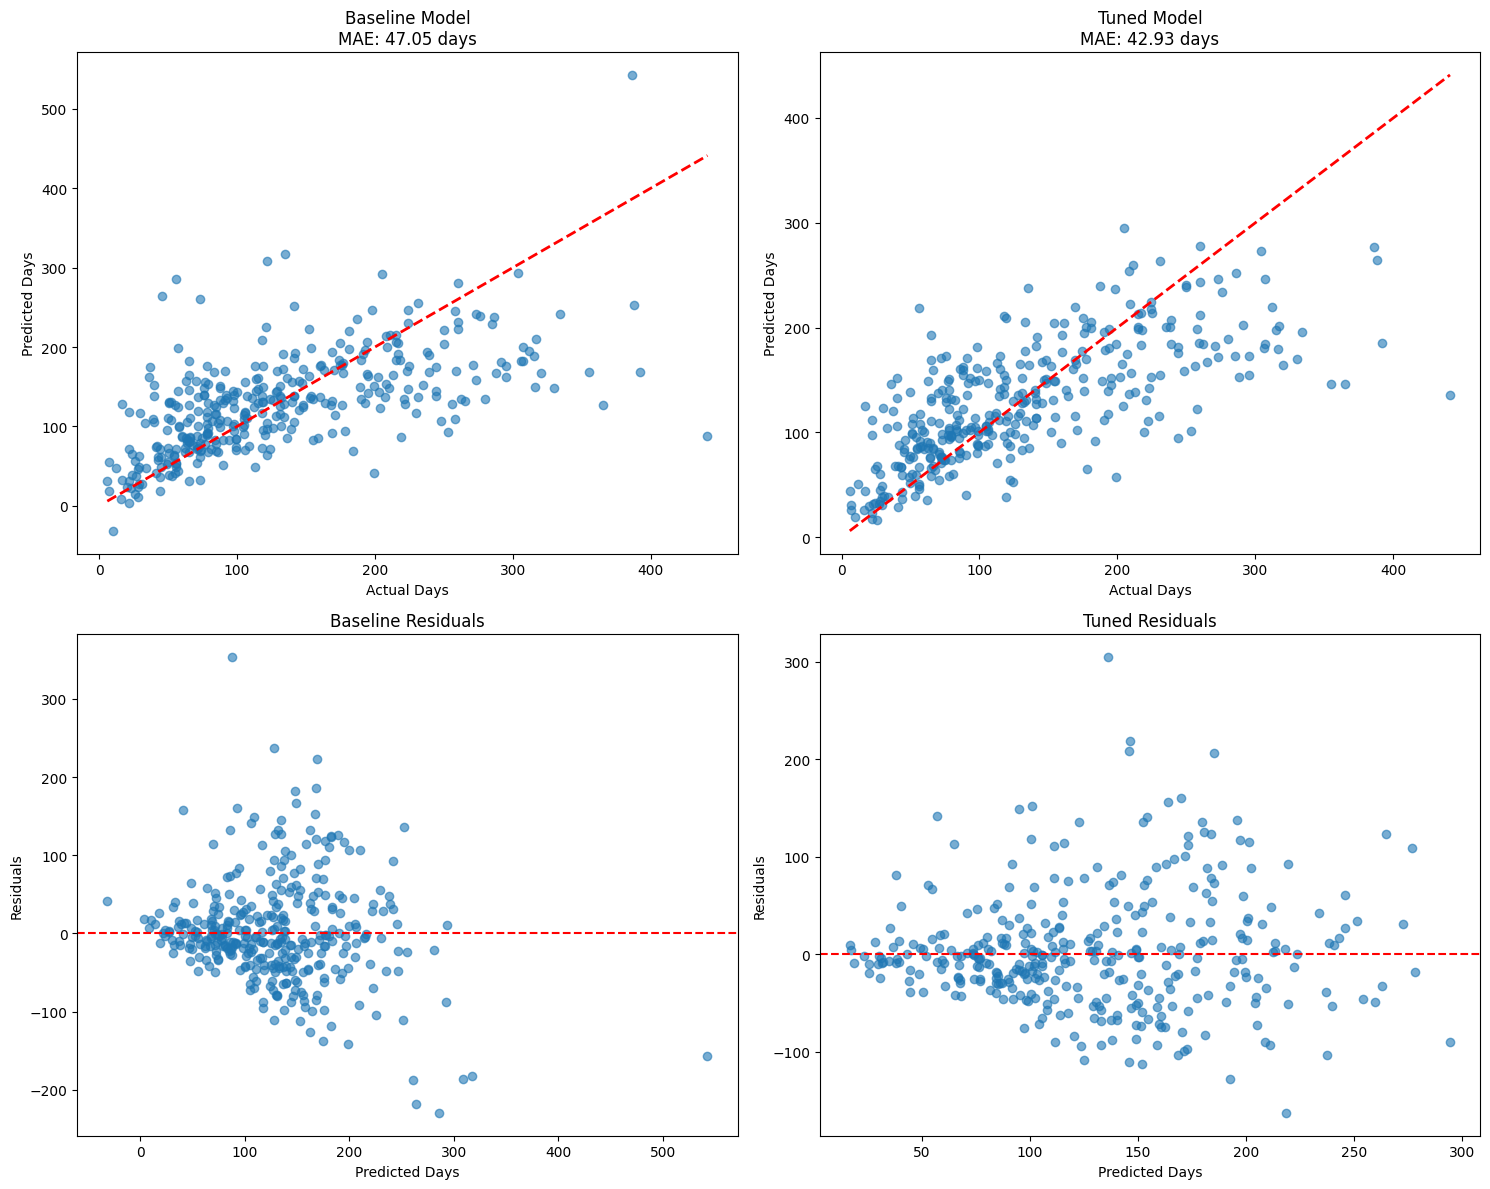

In [34]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted (Baseline)
axes[0, 0].scatter(y_test, baseline_results['predictions']['y_test_pred'], alpha=0.6)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Days')
axes[0, 0].set_ylabel('Predicted Days')
axes[0, 0].set_title(f'Baseline Model\nMAE: {baseline_results["metrics"]["test_mae"]:.2f} days')

# 2. Actual vs Predicted (Tuned)
axes[0, 1].scatter(y_test, tuned_results['predictions']['y_test_pred'], alpha=0.6)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Days')
axes[0, 1].set_ylabel('Predicted Days')
axes[0, 1].set_title(f'Tuned Model\nMAE: {tuned_results["metrics"]["test_mae"]:.2f} days')

# 3. Residuals (Baseline)
baseline_residuals = y_test - baseline_results['predictions']['y_test_pred']
axes[1, 0].scatter(baseline_results['predictions']['y_test_pred'], baseline_residuals, alpha=0.6)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Predicted Days')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Baseline Residuals')

# 4. Residuals (Tuned)
tuned_residuals = y_test - tuned_results['predictions']['y_test_pred']
axes[1, 1].scatter(tuned_results['predictions']['y_test_pred'], tuned_residuals, alpha=0.6)
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Predicted Days')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Tuned Residuals')

plt.tight_layout()
plt.show()